In [19]:
import sys
sys.path.insert(0,'/cis/home/leebc/Projects/Mouse_Histology/code/pytorch/') # add code directory to path
# import lddmm
import torch_lddmm
# import numpy
import numpy as np
# import nibabel for i/o
import nibabel as nib
# import matplotlib for display
import matplotlib.pyplot as plt
import torch
import SimpleITK as sitk

SimpleITK's procedural API provides three methods for performing resampling, with the difference being the way you specify the resampling grid:

Resample(const Image &image1, Transform transform, InterpolatorEnum interpolator, double defaultPixelValue, PixelIDValueEnum outputPixelType)

Resample(const Image &image1, const Image &referenceImage, Transform transform, InterpolatorEnum interpolator, double defaultPixelValue, PixelIDValueEnum outputPixelType)

Resample(const Image &image1, std::vector< uint32_t > size, Transform transform, InterpolatorEnum interpolator, std::vector< double > outputOrigin, std::vector< double > outputSpacing, std::vector< double > outputDirection, double defaultPixelValue, PixelIDValueEnum outputPixelType)

Below we use the third resampling method.

The goal is to make the target file (the SMI file) the same as the MRI file

<class 'SimpleITK.SimpleITK.Image'>
(0.004000000189989805, 0.004000000189989805, 1.0)
(220, 116, 14)
[98.23226112 59.23475875  6.57543992] target
[392.27772958 198.87809045  23.36704865] mri
asdf (5930, 2687, 6)


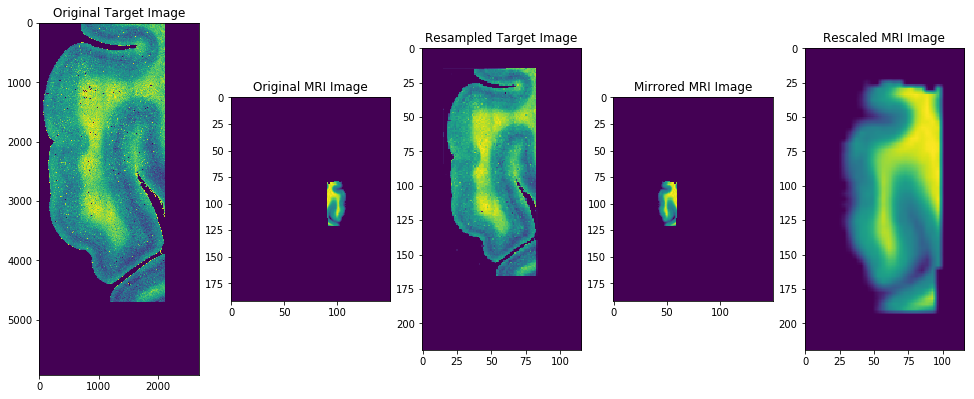

In [20]:
# load mouse brain histology and mri images
target_file_name = '/cis/home/jtrieu/Documents/WK0145_SMI_v5_reversed.img'
mri_file_name = '/cis/home/jtrieu/Documents/WK0145_20191120.img'

# resample target file to make it the same size as the mri file
mri_sitk = sitk.ReadImage(mri_file_name)    
target_sitk = sitk.ReadImage(target_file_name)

# removing the 4th dimension from the target file
target_data = sitk.GetArrayFromImage(target_sitk)
target_data = np.squeeze(target_data)
target_3D = sitk.GetImageFromArray(target_data)
target_3D.SetSpacing([target_sitk.GetSpacing()[0],target_sitk.GetSpacing()[1],target_sitk.GetSpacing()[3]])
print(type(target_3D))

# save the new 3D target image
sitk.WriteImage(target_3D,'/cis/home/jtrieu/Documents/WK0145_3D_SMI_v5_reversed.img')

# update target file name
target_file_name = '/cis/home/jtrieu/Documents/WK0145_3D_SMI_v5_reversed.img'

# read in new target that's been reduced from 4->3 dimensions
target_sitk = sitk.ReadImage(target_file_name)
print(target_sitk.GetSpacing())

# resample the target image
#output_size = [mri_sitk.GetSize()[0],mri_sitk.GetSize()[1],target_3D.GetSize()[2]]
output_spacing = [mri_sitk.GetSpacing()[0]/4,mri_sitk.GetSpacing()[1]/4,target_3D.GetSpacing()[2]]
output_size = [int(np.round(target_3D.GetSize()[0]*target_3D.GetSpacing()[0]/output_spacing[0])),
               int(np.round(target_3D.GetSize()[1]*target_3D.GetSpacing()[1]/output_spacing[1])),
               target_3D.GetSize()[2]]
target_resample = sitk.Resample(sitk.SmoothingRecursiveGaussian(target_3D,
                                                                target_3D.GetSpacing()[0]*2),
                                                                output_size,
                                                                sitk.AffineTransform(3),
                                                                sitk.sitkLinear,
                                                                (0,0,0),
                                                                output_spacing,
                                                                (1,0,0,0,1,0,0,0,1), 0.0)

# pad the resampled target
target_resample_np = np.transpose(sitk.GetArrayFromImage(target_resample),(2,1,0))
pad_amount = [15,15,4]
target_padded_np = np.zeros((target_resample_np.shape[0]+pad_amount[0]*2,target_resample_np.shape[1]+pad_amount[1]*2,target_resample_np.shape[2]+pad_amount[2]*2))
target_padded_np[pad_amount[0]:-pad_amount[0],pad_amount[1]:-pad_amount[1],pad_amount[2]:-pad_amount[2]] = target_resample_np

target_resample = sitk.GetImageFromArray(np.transpose(target_padded_np,(2,1,0)))
target_resample.SetSpacing(output_spacing)

print(target_resample.GetSize())

# save the new 3D target resampled image
sitk.WriteImage(target_resample,'/cis/home/jtrieu/Documents/WK0145_3D_SMI_resampled.img')

# update target file name to new 3D target resampled image
target_file_name = '/cis/home/jtrieu/Documents/WK0145_3D_SMI_resampled.img'

# load mri and target data into numpy arrays
target_image_struct = nib.load(target_file_name)
mri_image_struct = nib.load(mri_file_name)
target_image = np.squeeze(target_image_struct.get_data()).astype(np.float32)
mri_image = np.squeeze(mri_image_struct.get_data()).astype(np.float32)

mri_image_mirrored = mri_image[:,mri_image.shape[1]:None:-1,:] # mirror mri in y dimension
mri_image_mirrored_sitk = sitk.GetImageFromArray(np.transpose(mri_image_mirrored,(2,1,0)))
mri_image_mirrored_sitk.SetSpacing(mri_sitk.GetSpacing())
mri_output_size = [int(np.round(mri_sitk.GetSize()[0]*mri_sitk.GetSpacing()[0]/output_spacing[0])),int(np.round(mri_sitk.GetSize()[1]*mri_sitk.GetSpacing()[1]/output_spacing[1])),int(np.round(mri_sitk.GetSize()[2]*mri_sitk.GetSpacing()[2]/output_spacing[2]))]
mri_resample = sitk.Resample(mri_image_mirrored_sitk, mri_output_size, sitk.AffineTransform(3), sitk.sitkLinear,
                             (0,0,0), output_spacing, (1,0,0,0,1,0,0,0,1), 0.0)

target_center_of_mass = np.mean(np.where(np.transpose(sitk.GetArrayFromImage(target_resample),(2,1,0)) > np.mean(np.transpose(sitk.GetArrayFromImage(target_resample),(2,1,0)))),axis=1)
mri_center_of_mass = np.mean(np.where(np.transpose(sitk.GetArrayFromImage(mri_resample),(2,1,0)) > np.mean(np.transpose(sitk.GetArrayFromImage(mri_resample),(2,1,0)))),axis=1)
print(target_center_of_mass, 'target')
print(mri_center_of_mass,'mri')

# plot translated, resampled target image
translation = sitk.TranslationTransform(3)
translation.SetOffset((-(target_center_of_mass[0]-mri_center_of_mass[0])*mri_resample.GetSpacing()[0],
                       -(target_center_of_mass[1]-mri_center_of_mass[1])*mri_resample.GetSpacing()[1],
                       -(target_center_of_mass[2]-mri_center_of_mass[2])*mri_resample.GetSpacing()[2]))
mri_transform = sitk.Resample(mri_resample, target_resample.GetSize(), translation, sitk.sitkLinear,
                                 (0,0,0), output_spacing, (1,0,0,0,1,0,0,0,1), 0.0)

# display slices
plt.rcParams["figure.figsize"]=20,20
plt.figure()

# plot original target image
plt.subplot(1,6,1)
plt.title('Original Target Image')
plt.imshow(np.transpose(sitk.GetArrayFromImage(target_3D),(2,1,0))[:,:,1])
target_asdf = np.transpose(sitk.GetArrayFromImage(target_3D),(2,1,0))
print('asdf',target_asdf.shape)

# plot original mri image
plt.subplot(1,6,2)
plt.imshow(mri_image[:,:,36])
plt.title('Original MRI Image')

# plot resampled target image
plt.subplot(1,6,3)
plt.title('Resampled Target Image')
plt.imshow(np.transpose(sitk.GetArrayFromImage(target_resample),(2,1,0))[:,:,5])

# plot mirrored mri image
plt.subplot(1,6,4)
plt.imshow(np.transpose(sitk.GetArrayFromImage(mri_image_mirrored_sitk),(2,1,0))[:,:,36])
plt.title('Mirrored MRI Image')

plt.subplot(1,6,5)
plt.imshow(np.transpose(sitk.GetArrayFromImage(mri_transform),(2,1,0))[:,:,1])
plt.title('Rescaled MRI Image')
plt.show()


sitk.WriteImage(target_resample,'/cis/home/jtrieu/Documents/target_resample.img')
sitk.WriteImage(mri_transform,'/cis/home/jtrieu/Documents/mri_transform.img')


## Start with alignment to self

In [21]:
# need to change these to numpy arrays
mri_transform_arr = np.transpose(sitk.GetArrayFromImage(mri_transform),[2,1,0])*255.0
target_resample_arr = np.transpose(sitk.GetArrayFromImage(target_resample),[2,1,0])

lddmm = torch_lddmm.LDDMM(template=[mri_transform_arr],target=[target_resample_arr],costmask=None,outdir='../notebook/',do_affine=2,do_lddmm=0,a=8,niter=150,epsilon=5e-3,sigma=[20.0],sigmaR=10.0,optimizer='gdr',
                          dx=output_spacing,cc=0,gpu_number = None,checkaffinestep=1)
lddmm._checkParameters()
lddmm._load(lddmm.params['template'],lddmm.params['target'],lddmm.params['costmask'])
lddmm.initializeVariables()
lddmm.initializeKernels()


Current parameters:
>    a               = 8 (smoothing kernel, a*(pixel_size))
>    p               = 2 (smoothing kernel power, p*2)
>    niter           = 150 (number of iterations)
>    epsilon         = 0.005 (gradient descent step size)
>    epsilonL        = 1e-07 (gradient descent step size, affine)
>    epsilonT        = 2e-05 (gradient descent step size, translation)
>    minbeta         = 0.0001 (smallest multiple of epsilon)
>    sigma           = [20.0] (matching term coefficient (0.5/sigma**2))
>    sigmaR          = 10.0 (regularization term coefficient (0.5/sigmaR**2))
>    nt              = 5 (number of time steps in velocity field)
>    do_lddmm        = 0 (perform LDDMM step, 0 = no, 1 = yes)
>    do_affine       = 2 (interleave linear registration: 0 = no, 1 = affine, 2 = rigid)
>    checkaffinestep = 1 (evaluate linear matching energy: 0 = no, 1 = yes)
>    im_norm_ms      = 0 (normalize image by mean and std: 0 = no, 1 = yes)
>    gpu_number      = None (index of

In [22]:
# Grab the indices of the missing slices
missingslices = []
for i in range(target_resample_arr.shape[2]):
    if np.unique(target_image[:,:,i]).shape[0] < 3:
        missingslices.append(i)
print(missingslices)


#origJ = lddmm.J[0].clone()
epsilonxy = 4e-7
epsilontheta=2e-7
a = None
b = None
theta = None
niter = 500

a,b,theta,outtarget,epsilonxy,epsilontheta = lddmm.sa(torch.tensor(target_resample_arr).type(torch.FloatTensor),torch.tensor(target_resample_arr).type(torch.FloatTensor),niter=niter,dim=2,norm=0,missingslices=missingslices,sigma_atlas=99999999999.0,sigma_target=50.0,a=a,b=b,theta=theta,nx=list(target_resample_arr.shape),dx=output_spacing,epsilonxy=epsilonxy*4, epsilontheta=epsilontheta*4, sigma_target_radius=1, sigma_atlas_radius=1)
#lddmm.setParams('a',4)
outtarget = lddmm.applySA(torch.tensor(target_resample_arr).type(torch.FloatTensor), a, b, theta, dim=2,nx=list(target_resample_arr.shape),dx=output_spacing).numpy().astype(np.float32)

[0, 1, 2, 3, 10, 11, 12, 13]
iter: 1, E= 2119.716, Eim_t= 2119.716, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000.
iter: 2, E= 2118.647, Eim_t= 2118.647, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 0.04.
iter: 3, E= 2115.562, Eim_t= 2115.562, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 0.04.
iter: 4, E= 2114.664, Eim_t= 2114.664, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 0.04.
iter: 5, E= 2111.440, Eim_t= 2111.440, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 0.04.
iter: 6, E= 2110.529, Eim_t= 2110.529, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 0.04.
iter: 7, E= 2107.362, Eim_t= 2107.362, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 0.04.
iter: 8, E= 2106.433, Eim_t= 2106.433, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 0.04.
iter: 9

iter: 71, E= 1976.705, Eim_t= 1976.699, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0061, ep_xy= 0.0000, ep_t= 0.0000, time= 0.04.
iter: 72, E= 1974.351, Eim_t= 1974.345, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0061, ep_xy= 0.0000, ep_t= 0.0000, time= 0.04.
iter: 73, E= 1972.098, Eim_t= 1972.092, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0066, ep_xy= 0.0000, ep_t= 0.0000, time= 0.04.
iter: 74, E= 1969.687, Eim_t= 1969.680, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0066, ep_xy= 0.0000, ep_t= 0.0000, time= 0.04.
iter: 75, E= 1967.509, Eim_t= 1967.501, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0071, ep_xy= 0.0000, ep_t= 0.0000, time= 0.04.
iter: 76, E= 1965.055, Eim_t= 1965.048, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0071, ep_xy= 0.0000, ep_t= 0.0000, time= 0.04.
iter: 77, E= 1962.984, Eim_t= 1962.976, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0076, ep_xy= 0.0000, ep_t= 0.0000, time= 0.04.
iter: 78, E= 1960.499, Eim_t= 1960.491, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0076, ep_xy= 0.0000, ep_t= 0.0000, time= 0.04.
iter: 79, E= 195

iter: 143, E= 1804.988, Eim_t= 1804.968, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0191, ep_xy= 0.0000, ep_t= 0.0000, time= 0.04.
iter: 144, E= 1798.583, Eim_t= 1798.563, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0191, ep_xy= 0.0000, ep_t= 0.0000, time= 0.04.
iter: 145, E= 1798.171, Eim_t= 1798.151, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0189, ep_xy= 0.0000, ep_t= 0.0000, time= 0.04.
iter: 146, E= 1791.548, Eim_t= 1791.529, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0189, ep_xy= 0.0000, ep_t= 0.0000, time= 0.04.
iter: 147, E= 1791.163, Eim_t= 1791.144, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0187, ep_xy= 0.0000, ep_t= 0.0000, time= 0.04.
iter: 148, E= 1784.298, Eim_t= 1784.279, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0187, ep_xy= 0.0000, ep_t= 0.0000, time= 0.04.
iter: 149, E= 1783.928, Eim_t= 1783.909, Eim_a= 0.000, ER_xy= 0.000, ER_t= 0.0185, ep_xy= 0.0000, ep_t= 0.0000, time= 0.04.
iter: 150, E= 1776.773, Eim_t= 1776.755, Eim_a= 0.000, ER_xy= 0.001, ER_t= 0.0185, ep_xy= 0.0000, ep_t= 0.0000, time= 0.04.
iter: 15

iter: 215, E= 1447.218, Eim_t= 1447.202, Eim_a= 0.000, ER_xy= 0.004, ER_t= 0.0114, ep_xy= 0.0001, ep_t= 0.0000, time= 0.04.
iter: 216, E= 1441.680, Eim_t= 1441.664, Eim_a= 0.000, ER_xy= 0.005, ER_t= 0.0114, ep_xy= 0.0001, ep_t= 0.0000, time= 0.04.
iter: 217, E= 1440.949, Eim_t= 1440.933, Eim_a= 0.000, ER_xy= 0.005, ER_t= 0.0114, ep_xy= 0.0001, ep_t= 0.0000, time= 0.04.
iter: 218, E= 1435.932, Eim_t= 1435.915, Eim_a= 0.000, ER_xy= 0.005, ER_t= 0.0114, ep_xy= 0.0001, ep_t= 0.0000, time= 0.04.
iter: 219, E= 1435.431, Eim_t= 1435.415, Eim_a= 0.000, ER_xy= 0.005, ER_t= 0.0113, ep_xy= 0.0001, ep_t= 0.0000, time= 0.04.
iter: 220, E= 1430.892, Eim_t= 1430.876, Eim_a= 0.000, ER_xy= 0.005, ER_t= 0.0113, ep_xy= 0.0001, ep_t= 0.0000, time= 0.04.
iter: 221, E= 1430.230, Eim_t= 1430.214, Eim_a= 0.000, ER_xy= 0.005, ER_t= 0.0113, ep_xy= 0.0001, ep_t= 0.0000, time= 0.04.
iter: 222, E= 1426.151, Eim_t= 1426.135, Eim_a= 0.000, ER_xy= 0.005, ER_t= 0.0113, ep_xy= 0.0001, ep_t= 0.0000, time= 0.04.
iter: 22

iter: 287, E= 1329.875, Eim_t= 1329.858, Eim_a= 0.000, ER_xy= 0.010, ER_t= 0.0063, ep_xy= 0.0004, ep_t= 0.0000, time= 0.04.
iter: 288, E= 1328.512, Eim_t= 1328.495, Eim_a= 0.000, ER_xy= 0.011, ER_t= 0.0063, ep_xy= 0.0005, ep_t= 0.0000, time= 0.04.
iter: 289, E= 1328.471, Eim_t= 1328.454, Eim_a= 0.000, ER_xy= 0.011, ER_t= 0.0062, ep_xy= 0.0005, ep_t= 0.0000, time= 0.04.
iter: 290, E= 1327.308, Eim_t= 1327.291, Eim_a= 0.000, ER_xy= 0.011, ER_t= 0.0062, ep_xy= 0.0005, ep_t= 0.0000, time= 0.04.
iter: 291, E= 1327.268, Eim_t= 1327.251, Eim_a= 0.000, ER_xy= 0.011, ER_t= 0.0061, ep_xy= 0.0005, ep_t= 0.0000, time= 0.04.
iter: 292, E= 1326.199, Eim_t= 1326.182, Eim_a= 0.000, ER_xy= 0.011, ER_t= 0.0061, ep_xy= 0.0005, ep_t= 0.0000, time= 0.04.
iter: 293, E= 1326.162, Eim_t= 1326.145, Eim_a= 0.000, ER_xy= 0.011, ER_t= 0.0059, ep_xy= 0.0005, ep_t= 0.0000, time= 0.04.
iter: 294, E= 1325.194, Eim_t= 1325.177, Eim_a= 0.000, ER_xy= 0.011, ER_t= 0.0059, ep_xy= 0.0005, ep_t= 0.0000, time= 0.04.
iter: 29

iter: 359, E= 1319.245, Eim_t= 1319.227, Eim_a= 0.000, ER_xy= 0.013, ER_t= 0.0045, ep_xy= 0.0007, ep_t= 0.0000, time= 0.04.
iter: 360, E= 1318.976, Eim_t= 1318.959, Eim_a= 0.000, ER_xy= 0.013, ER_t= 0.0045, ep_xy= 0.0008, ep_t= 0.0000, time= 0.04.
iter: 361, E= 1318.976, Eim_t= 1318.958, Eim_a= 0.000, ER_xy= 0.013, ER_t= 0.0045, ep_xy= 0.0008, ep_t= 0.0000, time= 0.04.
iter: 362, E= 1318.763, Eim_t= 1318.746, Eim_a= 0.000, ER_xy= 0.013, ER_t= 0.0045, ep_xy= 0.0008, ep_t= 0.0000, time= 0.04.
iter: 363, E= 1318.763, Eim_t= 1318.746, Eim_a= 0.000, ER_xy= 0.013, ER_t= 0.0045, ep_xy= 0.0008, ep_t= 0.0000, time= 0.04.
iter: 364, E= 1318.737, Eim_t= 1318.719, Eim_a= 0.000, ER_xy= 0.013, ER_t= 0.0045, ep_xy= 0.0008, ep_t= 0.0000, time= 0.04.
iter: 365, E= 1318.737, Eim_t= 1318.719, Eim_a= 0.000, ER_xy= 0.013, ER_t= 0.0045, ep_xy= 0.0008, ep_t= 0.0000, time= 0.04.
iter: 366, E= 1318.662, Eim_t= 1318.644, Eim_a= 0.000, ER_xy= 0.013, ER_t= 0.0045, ep_xy= 0.0009, ep_t= 0.0000, time= 0.04.
iter: 36

iter: 431, E= 1318.589, Eim_t= 1318.572, Eim_a= 0.000, ER_xy= 0.013, ER_t= 0.0045, ep_xy= 0.0000, ep_t= 0.0000, time= 0.04.
iter: 432, E= 1318.589, Eim_t= 1318.572, Eim_a= 0.000, ER_xy= 0.013, ER_t= 0.0045, ep_xy= 0.0000, ep_t= 0.0000, time= 0.04.
iter: 433, E= 1318.589, Eim_t= 1318.572, Eim_a= 0.000, ER_xy= 0.013, ER_t= 0.0045, ep_xy= 0.0000, ep_t= 0.0000, time= 0.04.
iter: 434, E= 1318.589, Eim_t= 1318.572, Eim_a= 0.000, ER_xy= 0.013, ER_t= 0.0045, ep_xy= 0.0000, ep_t= 0.0000, time= 0.04.
iter: 435, E= 1318.589, Eim_t= 1318.572, Eim_a= 0.000, ER_xy= 0.013, ER_t= 0.0045, ep_xy= 0.0000, ep_t= 0.0000, time= 0.04.
iter: 436, E= 1318.589, Eim_t= 1318.572, Eim_a= 0.000, ER_xy= 0.013, ER_t= 0.0045, ep_xy= 0.0000, ep_t= 0.0000, time= 0.04.
iter: 437, E= 1318.589, Eim_t= 1318.572, Eim_a= 0.000, ER_xy= 0.013, ER_t= 0.0045, ep_xy= 0.0000, ep_t= 0.0000, time= 0.04.
iter: 438, E= 1318.589, Eim_t= 1318.572, Eim_a= 0.000, ER_xy= 0.013, ER_t= 0.0045, ep_xy= 0.0000, ep_t= 0.0000, time= 0.04.
iter: 43

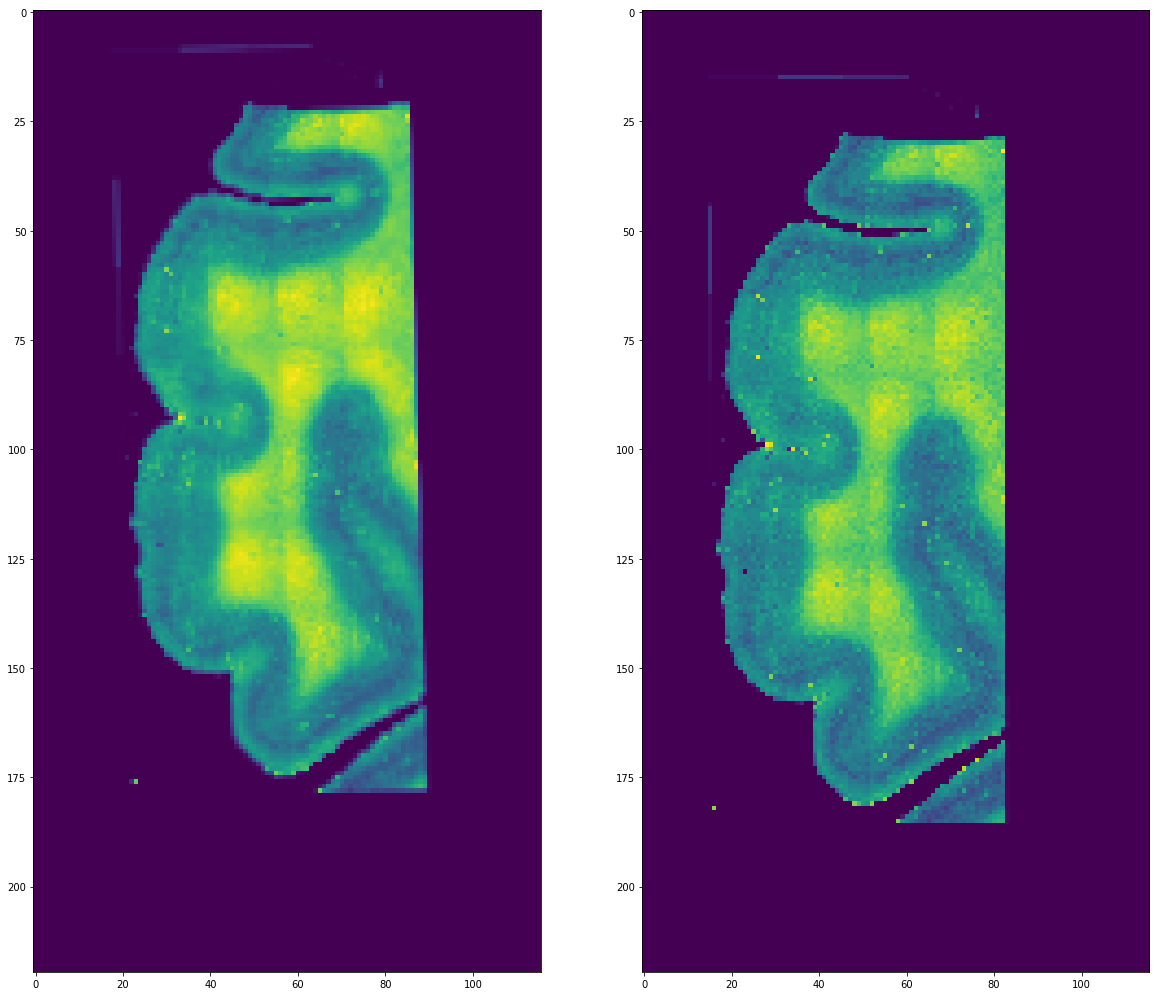

In [23]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(outtarget[:,:,6])
plt.subplot(1,2,2)
plt.imshow(target_resample_arr[:,:,6])
plt.show()

In [24]:
# check image
outimg = nib.AnalyzeImage(outtarget,None)
outimg.header['pixdim'][1:4] = output_spacing
nib.save(outimg,'/cis/home/jtrieu/Documents/target_resectioned.img')

## Start with rigid alignment

In [25]:
# need to change these to numpy arrays
mri_transform_arr = np.transpose(sitk.GetArrayFromImage(mri_transform),[2,1,0])*255.0
target_resample_arr = np.transpose(sitk.GetArrayFromImage(target_resample),[2,1,0])

mri_transform_arr[:,:,9:] = 0
mri_translated = np.zeros(mri_transform_arr.shape)
mri_translated[:,:,3:-3] = mri_transform_arr[:,:,0:8]


costmask = np.zeros(target_resample_arr.shape)
costmask[np.where(target_resample_arr != 0)] = 1

print(np.max(mri_transform_arr))
print(np.max(outtarget))
print(np.min(mri_transform_arr))
print(np.min(outtarget))

lddmm = torch_lddmm.LDDMM(template=[mri_translated],target=[outtarget],costmask=costmask,outdir='../notebook/',do_affine=2,do_lddmm=0,a=8,niter=150,epsilon=5e-3,sigma=[20.0],sigmaR=10.0,optimizer='gdr',
                          dx=output_spacing,cc=1,gpu_number = 1)

213.75468
198.93884
0.0
-0.1435687

Current parameters:
>    a               = 8 (smoothing kernel, a*(pixel_size))
>    p               = 2 (smoothing kernel power, p*2)
>    niter           = 150 (number of iterations)
>    epsilon         = 0.005 (gradient descent step size)
>    epsilonL        = 1e-07 (gradient descent step size, affine)
>    epsilonT        = 2e-05 (gradient descent step size, translation)
>    minbeta         = 0.0001 (smallest multiple of epsilon)
>    sigma           = [20.0] (matching term coefficient (0.5/sigma**2))
>    sigmaR          = 10.0 (regularization term coefficient (0.5/sigmaR**2))
>    nt              = 5 (number of time steps in velocity field)
>    do_lddmm        = 0 (perform LDDMM step, 0 = no, 1 = yes)
>    do_affine       = 2 (interleave linear registration: 0 = no, 1 = affine, 2 = rigid)
>    checkaffinestep = 0 (evaluate linear matching energy: 0 = no, 1 = yes)
>    im_norm_ms      = 0 (normalize image by mean and std: 0 = no, 1 = yes)
> 

In [26]:
%%time
lddmm.setParams('niter',500)
# translation
lddmm.setParams('epsilonL',1e-99)
lddmm.setParams('epsilonT',2e-5)
lddmm.run()
# translation + rotation
lddmm.setParams('epsilonL',1e-5)
lddmm.setParams('epsilonT',2e-5)
lddmm.run()
# affine
lddmm.setParams('do_affine',1)
lddmm.setParams('epsilonL',1e-5)
lddmm.setParams('epsilonT',2e-5)
lddmm.run()
# 
print(lddmm.affineA)

Parameter 'niter' changed to '500'.
Parameter 'epsilonL' changed to '1e-99'.
Parameter 'epsilonT' changed to '2e-05'.
iter: 0, E = 3658.8354, ER = 0.0000, EM = 3658.8354, epd = 0.005000.
iter: 1, E= 3649.284, ER= 0.000, EM= 3649.284, epd= 0.005, time= 0.04s.
iter: 2, E= 3639.774, ER= 0.000, EM= 3639.774, epd= 0.005, time= 0.04s.
iter: 3, E= 3630.312, ER= 0.000, EM= 3630.312, epd= 0.005, time= 0.03s.
iter: 4, E= 3620.901, ER= 0.000, EM= 3620.901, epd= 0.005, time= 0.03s.
iter: 5, E= 3611.547, ER= 0.000, EM= 3611.547, epd= 0.005, time= 0.04s.
iter: 6, E= 3602.253, ER= 0.000, EM= 3602.253, epd= 0.005, time= 0.04s.
iter: 7, E= 3593.025, ER= 0.000, EM= 3593.025, epd= 0.005, time= 0.03s.
iter: 8, E= 3583.867, ER= 0.000, EM= 3583.867, epd= 0.005, time= 0.03s.
iter: 9, E= 3574.783, ER= 0.000, EM= 3574.783, epd= 0.005, time= 0.03s.
iter: 10, E= 3565.780, ER= 0.000, EM= 3565.780, epd= 0.005, time= 0.03s.
iter: 11, E= 3556.861, ER= 0.000, EM= 3556.861, epd= 0.005, time= 0.03s.
iter: 12, E= 3548.0

iter: 116, E= 2670.111, ER= 0.000, EM= 2670.111, epd= 0.005, time= 0.03s.
iter: 117, E= 2666.337, ER= 0.000, EM= 2666.337, epd= 0.005, time= 0.03s.
iter: 118, E= 2662.721, ER= 0.000, EM= 2662.721, epd= 0.005, time= 0.03s.
iter: 119, E= 2659.259, ER= 0.000, EM= 2659.259, epd= 0.005, time= 0.03s.
iter: 120, E= 2655.948, ER= 0.000, EM= 2655.948, epd= 0.005, time= 0.03s.
iter: 121, E= 2652.784, ER= 0.000, EM= 2652.784, epd= 0.005, time= 0.03s.
iter: 122, E= 2649.764, ER= 0.000, EM= 2649.764, epd= 0.005, time= 0.03s.
iter: 123, E= 2646.884, ER= 0.000, EM= 2646.884, epd= 0.005, time= 0.03s.
iter: 124, E= 2644.141, ER= 0.000, EM= 2644.141, epd= 0.005, time= 0.03s.
iter: 125, E= 2641.530, ER= 0.000, EM= 2641.530, epd= 0.005, time= 0.03s.
iter: 126, E= 2639.049, ER= 0.000, EM= 2639.049, epd= 0.005, time= 0.03s.
iter: 127, E= 2636.693, ER= 0.000, EM= 2636.693, epd= 0.005, time= 0.03s.
iter: 128, E= 2634.459, ER= 0.000, EM= 2634.459, epd= 0.005, time= 0.03s.
iter: 129, E= 2632.345, ER= 0.000, EM=

iter: 228, E= 2551.305, ER= 0.000, EM= 2551.305, epd= 0.005, time= 0.03s.
iter: 229, E= 2551.235, ER= 0.000, EM= 2551.235, epd= 0.005, time= 0.03s.
iter: 230, E= 2551.169, ER= 0.000, EM= 2551.169, epd= 0.005, time= 0.03s.
iter: 231, E= 2551.107, ER= 0.000, EM= 2551.107, epd= 0.005, time= 0.03s.
iter: 232, E= 2551.047, ER= 0.000, EM= 2551.047, epd= 0.005, time= 0.03s.
iter: 233, E= 2550.992, ER= 0.000, EM= 2550.992, epd= 0.005, time= 0.03s.
iter: 234, E= 2550.939, ER= 0.000, EM= 2550.939, epd= 0.005, time= 0.03s.
iter: 235, E= 2550.890, ER= 0.000, EM= 2550.890, epd= 0.005, time= 0.03s.
iter: 236, E= 2550.843, ER= 0.000, EM= 2550.843, epd= 0.005, time= 0.03s.
iter: 237, E= 2550.799, ER= 0.000, EM= 2550.799, epd= 0.005, time= 0.03s.
iter: 238, E= 2550.757, ER= 0.000, EM= 2550.757, epd= 0.005, time= 0.03s.
iter: 239, E= 2550.718, ER= 0.000, EM= 2550.718, epd= 0.005, time= 0.03s.
iter: 240, E= 2550.680, ER= 0.000, EM= 2550.680, epd= 0.005, time= 0.03s.
iter: 241, E= 2550.646, ER= 0.000, EM=

iter: 65, E= 2506.373, ER= 0.000, EM= 2506.373, epd= 0.005, time= 0.03s.
iter: 66, E= 2506.291, ER= 0.000, EM= 2506.291, epd= 0.005, time= 0.03s.
iter: 67, E= 2506.211, ER= 0.000, EM= 2506.211, epd= 0.005, time= 0.03s.
iter: 68, E= 2506.131, ER= 0.000, EM= 2506.131, epd= 0.005, time= 0.03s.
iter: 69, E= 2506.055, ER= 0.000, EM= 2506.055, epd= 0.005, time= 0.03s.
iter: 70, E= 2505.981, ER= 0.000, EM= 2505.981, epd= 0.005, time= 0.03s.
iter: 71, E= 2505.910, ER= 0.000, EM= 2505.910, epd= 0.005, time= 0.03s.
iter: 72, E= 2505.840, ER= 0.000, EM= 2505.840, epd= 0.005, time= 0.03s.
iter: 73, E= 2505.773, ER= 0.000, EM= 2505.773, epd= 0.005, time= 0.03s.
iter: 74, E= 2505.706, ER= 0.000, EM= 2505.706, epd= 0.005, time= 0.03s.
iter: 75, E= 2505.640, ER= 0.000, EM= 2505.640, epd= 0.005, time= 0.03s.
iter: 76, E= 2505.577, ER= 0.000, EM= 2505.577, epd= 0.005, time= 0.03s.
iter: 77, E= 2505.515, ER= 0.000, EM= 2505.515, epd= 0.005, time= 0.03s.
iter: 78, E= 2505.456, ER= 0.000, EM= 2505.456, epd

iter: 26, E= 2125.195, ER= 0.000, EM= 2125.195, epd= 0.005, time= 0.03s.
iter: 27, E= 2120.679, ER= 0.000, EM= 2120.679, epd= 0.005, time= 0.03s.
iter: 28, E= 2116.303, ER= 0.000, EM= 2116.303, epd= 0.005, time= 0.03s.
iter: 29, E= 2112.031, ER= 0.000, EM= 2112.031, epd= 0.005, time= 0.03s.
iter: 30, E= 2107.824, ER= 0.000, EM= 2107.824, epd= 0.005, time= 0.03s.
iter: 31, E= 2103.646, ER= 0.000, EM= 2103.646, epd= 0.005, time= 0.03s.
iter: 32, E= 2099.487, ER= 0.000, EM= 2099.487, epd= 0.005, time= 0.03s.
iter: 33, E= 2095.349, ER= 0.000, EM= 2095.349, epd= 0.005, time= 0.03s.
iter: 34, E= 2091.242, ER= 0.000, EM= 2091.242, epd= 0.005, time= 0.03s.
iter: 35, E= 2087.178, ER= 0.000, EM= 2087.178, epd= 0.005, time= 0.03s.
iter: 36, E= 2083.163, ER= 0.000, EM= 2083.163, epd= 0.005, time= 0.03s.
iter: 37, E= 2079.200, ER= 0.000, EM= 2079.200, epd= 0.005, time= 0.03s.
iter: 38, E= 2075.303, ER= 0.000, EM= 2075.303, epd= 0.005, time= 0.03s.
iter: 39, E= 2071.479, ER= 0.000, EM= 2071.479, epd

iter: 140, E= 1914.746, ER= 0.000, EM= 1914.746, epd= 0.005, time= 0.03s.
iter: 141, E= 1913.982, ER= 0.000, EM= 1913.982, epd= 0.005, time= 0.03s.
iter: 142, E= 1913.226, ER= 0.000, EM= 1913.226, epd= 0.005, time= 0.03s.
iter: 143, E= 1912.478, ER= 0.000, EM= 1912.478, epd= 0.005, time= 0.03s.
iter: 144, E= 1911.738, ER= 0.000, EM= 1911.738, epd= 0.005, time= 0.03s.
iter: 145, E= 1911.005, ER= 0.000, EM= 1911.005, epd= 0.005, time= 0.03s.
iter: 146, E= 1910.279, ER= 0.000, EM= 1910.279, epd= 0.005, time= 0.03s.
iter: 147, E= 1909.560, ER= 0.000, EM= 1909.560, epd= 0.005, time= 0.03s.
iter: 148, E= 1908.848, ER= 0.000, EM= 1908.848, epd= 0.005, time= 0.03s.
iter: 149, E= 1908.142, ER= 0.000, EM= 1908.142, epd= 0.005, time= 0.03s.
iter: 150, E= 1907.443, ER= 0.000, EM= 1907.443, epd= 0.005, time= 0.03s.
iter: 151, E= 1906.750, ER= 0.000, EM= 1906.750, epd= 0.005, time= 0.03s.
iter: 152, E= 1906.063, ER= 0.000, EM= 1906.063, epd= 0.005, time= 0.03s.
iter: 153, E= 1905.381, ER= 0.000, EM=

iter: 252, E= 1857.221, ER= 0.000, EM= 1857.221, epd= 0.005, time= 0.03s.
iter: 253, E= 1856.862, ER= 0.000, EM= 1856.862, epd= 0.005, time= 0.03s.
iter: 254, E= 1856.504, ER= 0.000, EM= 1856.504, epd= 0.005, time= 0.03s.
iter: 255, E= 1856.147, ER= 0.000, EM= 1856.147, epd= 0.005, time= 0.03s.
iter: 256, E= 1855.792, ER= 0.000, EM= 1855.792, epd= 0.005, time= 0.03s.
iter: 257, E= 1855.438, ER= 0.000, EM= 1855.438, epd= 0.005, time= 0.03s.
iter: 258, E= 1855.085, ER= 0.000, EM= 1855.085, epd= 0.005, time= 0.03s.
iter: 259, E= 1854.733, ER= 0.000, EM= 1854.733, epd= 0.005, time= 0.03s.
iter: 260, E= 1854.382, ER= 0.000, EM= 1854.382, epd= 0.005, time= 0.03s.
iter: 261, E= 1854.032, ER= 0.000, EM= 1854.032, epd= 0.005, time= 0.03s.
iter: 262, E= 1853.683, ER= 0.000, EM= 1853.683, epd= 0.005, time= 0.03s.
iter: 263, E= 1853.337, ER= 0.000, EM= 1853.337, epd= 0.005, time= 0.03s.
iter: 264, E= 1852.992, ER= 0.000, EM= 1852.992, epd= 0.005, time= 0.03s.
iter: 265, E= 1852.647, ER= 0.000, EM=

iter: 364, E= 1824.348, ER= 0.000, EM= 1824.348, epd= 0.005, time= 0.03s.
iter: 365, E= 1824.118, ER= 0.000, EM= 1824.118, epd= 0.005, time= 0.03s.
iter: 366, E= 1823.889, ER= 0.000, EM= 1823.889, epd= 0.005, time= 0.03s.
iter: 367, E= 1823.660, ER= 0.000, EM= 1823.660, epd= 0.005, time= 0.03s.
iter: 368, E= 1823.433, ER= 0.000, EM= 1823.433, epd= 0.005, time= 0.03s.
iter: 369, E= 1823.206, ER= 0.000, EM= 1823.206, epd= 0.005, time= 0.03s.
iter: 370, E= 1822.981, ER= 0.000, EM= 1822.981, epd= 0.005, time= 0.03s.
iter: 371, E= 1822.756, ER= 0.000, EM= 1822.756, epd= 0.005, time= 0.03s.
iter: 372, E= 1822.533, ER= 0.000, EM= 1822.533, epd= 0.005, time= 0.03s.
iter: 373, E= 1822.311, ER= 0.000, EM= 1822.311, epd= 0.005, time= 0.03s.
iter: 374, E= 1822.089, ER= 0.000, EM= 1822.089, epd= 0.005, time= 0.03s.
iter: 375, E= 1821.869, ER= 0.000, EM= 1821.869, epd= 0.005, time= 0.03s.
iter: 376, E= 1821.649, ER= 0.000, EM= 1821.649, epd= 0.005, time= 0.03s.
iter: 377, E= 1821.430, ER= 0.000, EM=

iter: 476, E= 1803.332, ER= 0.000, EM= 1803.332, epd= 0.005, time= 0.03s.
iter: 477, E= 1803.183, ER= 0.000, EM= 1803.183, epd= 0.005, time= 0.03s.
iter: 478, E= 1803.034, ER= 0.000, EM= 1803.034, epd= 0.005, time= 0.03s.
iter: 479, E= 1802.886, ER= 0.000, EM= 1802.886, epd= 0.005, time= 0.03s.
iter: 480, E= 1802.740, ER= 0.000, EM= 1802.740, epd= 0.005, time= 0.03s.
iter: 481, E= 1802.594, ER= 0.000, EM= 1802.594, epd= 0.005, time= 0.03s.
iter: 482, E= 1802.448, ER= 0.000, EM= 1802.448, epd= 0.005, time= 0.03s.
iter: 483, E= 1802.303, ER= 0.000, EM= 1802.303, epd= 0.005, time= 0.03s.
iter: 484, E= 1802.159, ER= 0.000, EM= 1802.159, epd= 0.005, time= 0.03s.
iter: 485, E= 1802.016, ER= 0.000, EM= 1802.016, epd= 0.005, time= 0.03s.
iter: 486, E= 1801.873, ER= 0.000, EM= 1801.873, epd= 0.005, time= 0.03s.
iter: 487, E= 1801.731, ER= 0.000, EM= 1801.731, epd= 0.005, time= 0.03s.
iter: 488, E= 1801.589, ER= 0.000, EM= 1801.589, epd= 0.005, time= 0.03s.
iter: 489, E= 1801.448, ER= 0.000, EM=

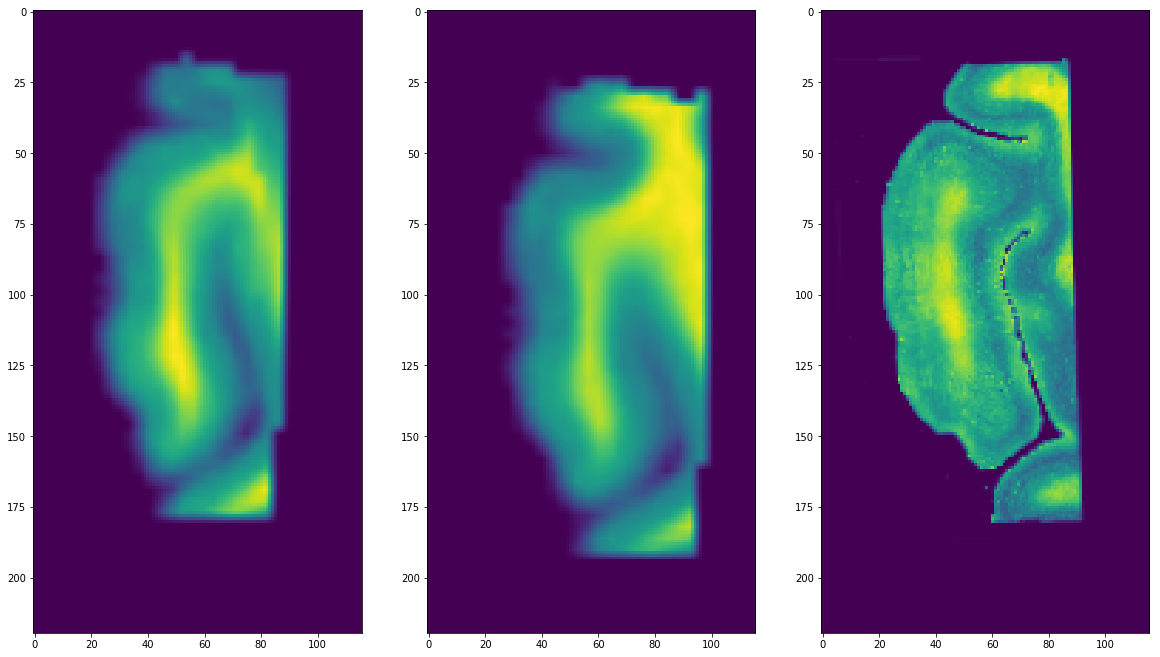

In [27]:
mri_translated_rigid = (lddmm.applyThisTransform(mri_translated))[0][-1].cpu().numpy()

plt.figure()
plt.subplot(1,3,1)
plt.imshow(mri_translated_rigid[:,:,4])
plt.subplot(1,3,2) 
plt.imshow(mri_translated[:,:,4])
plt.subplot(1,3,3) 
plt.imshow(outtarget[:,:,4])
plt.show()


# do something to align the histology to the mri and itself

iter: 1, E= 3373.729, Eim_t= 2119.716, Eim_a= 1254.013, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000.
iter: 2, E= 3370.300, Eim_t= 2117.827, Eim_a= 1252.473, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 0.03.
iter: 3, E= 3362.065, Eim_t= 2113.096, Eim_a= 1248.969, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 4, E= 3359.096, Eim_t= 2111.500, Eim_a= 1247.596, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 5, E= 3350.744, Eim_t= 2106.706, Eim_a= 1244.038, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 6, E= 3347.755, Eim_t= 2105.104, Eim_a= 1242.650, ER_xy= 0.000, ER_t= 0.0000, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 7, E= 3339.815, Eim_t= 2100.576, Eim_a= 1239.240, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 8, E= 3336.788, Eim_t= 2098.959, Eim_a= 1237.829, ER_xy= 0.000, ER_t= 0.0001, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 9, E= 

iter: 70, E= 3007.989, Eim_t= 1924.983, Eim_a= 1082.992, ER_xy= 0.000, ER_t= 0.0132, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 71, E= 3004.681, Eim_t= 1923.179, Eim_a= 1081.488, ER_xy= 0.000, ER_t= 0.0140, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 72, E= 2997.743, Eim_t= 1919.592, Eim_a= 1078.137, ER_xy= 0.000, ER_t= 0.0140, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 73, E= 2994.642, Eim_t= 1917.880, Eim_a= 1076.748, ER_xy= 0.000, ER_t= 0.0148, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 74, E= 2987.542, Eim_t= 1914.212, Eim_a= 1073.316, ER_xy= 0.000, ER_t= 0.0148, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 75, E= 2984.738, Eim_t= 1912.652, Eim_a= 1072.071, ER_xy= 0.000, ER_t= 0.0156, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 76, E= 2977.475, Eim_t= 1908.903, Eim_a= 1068.556, ER_xy= 0.000, ER_t= 0.0156, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 77, E= 2975.014, Eim_t= 1907.531, Eim_a= 1067.467, ER_xy= 0.000, ER_t= 0.0164, ep_xy= 0.0000, ep_t= 0.0000, time

iter: 140, E= 2568.902, Eim_t= 1691.619, Eim_a= 877.263, ER_xy= 0.001, ER_t= 0.0190, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 141, E= 2568.089, Eim_t= 1690.824, Eim_a= 877.246, ER_xy= 0.001, ER_t= 0.0186, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 142, E= 2549.259, Eim_t= 1680.501, Eim_a= 868.738, ER_xy= 0.001, ER_t= 0.0186, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 143, E= 2548.879, Eim_t= 1679.941, Eim_a= 868.919, ER_xy= 0.001, ER_t= 0.0181, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 144, E= 2529.150, Eim_t= 1669.057, Eim_a= 860.074, ER_xy= 0.001, ER_t= 0.0181, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 145, E= 2528.658, Eim_t= 1668.417, Eim_a= 860.223, ER_xy= 0.001, ER_t= 0.0176, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 146, E= 2508.092, Eim_t= 1656.983, Eim_a= 851.090, ER_xy= 0.001, ER_t= 0.0176, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 147, E= 2507.551, Eim_t= 1656.306, Eim_a= 851.226, ER_xy= 0.001, ER_t= 0.0171, ep_xy= 0.0000, ep_t= 0.0000, time

iter: 210, E= 2005.562, Eim_t= 1390.316, Eim_a= 615.234, ER_xy= 0.007, ER_t= 0.0057, ep_xy= 0.0001, ep_t= 0.0000, time= 0.02.
iter: 211, E= 2005.537, Eim_t= 1390.209, Eim_a= 615.316, ER_xy= 0.007, ER_t= 0.0054, ep_xy= 0.0001, ep_t= 0.0000, time= 0.02.
iter: 212, E= 1998.849, Eim_t= 1386.926, Eim_a= 611.910, ER_xy= 0.007, ER_t= 0.0054, ep_xy= 0.0001, ep_t= 0.0000, time= 0.02.
iter: 213, E= 1998.836, Eim_t= 1386.823, Eim_a= 612.001, ER_xy= 0.007, ER_t= 0.0052, ep_xy= 0.0001, ep_t= 0.0000, time= 0.02.
iter: 214, E= 1992.344, Eim_t= 1383.625, Eim_a= 608.707, ER_xy= 0.007, ER_t= 0.0052, ep_xy= 0.0001, ep_t= 0.0000, time= 0.02.
iter: 215, E= 1993.490, Eim_t= 1384.352, Eim_a= 609.125, ER_xy= 0.007, ER_t= 0.0049, ep_xy= 0.0001, ep_t= 0.0000, time= 0.02.
iter: 216, E= 1986.841, Eim_t= 1380.890, Eim_a= 605.939, ER_xy= 0.008, ER_t= 0.0049, ep_xy= 0.0001, ep_t= 0.0000, time= 0.02.
iter: 217, E= 1986.050, Eim_t= 1380.186, Eim_a= 605.852, ER_xy= 0.008, ER_t= 0.0047, ep_xy= 0.0001, ep_t= 0.0000, time

iter: 280, E= 1880.659, Eim_t= 1321.675, Eim_a= 558.969, ER_xy= 0.013, ER_t= 0.0019, ep_xy= 0.0004, ep_t= 0.0000, time= 0.02.
iter: 281, E= 1880.559, Eim_t= 1321.598, Eim_a= 558.946, ER_xy= 0.013, ER_t= 0.0019, ep_xy= 0.0004, ep_t= 0.0000, time= 0.02.
iter: 282, E= 1880.292, Eim_t= 1321.642, Eim_a= 558.635, ER_xy= 0.013, ER_t= 0.0019, ep_xy= 0.0004, ep_t= 0.0000, time= 0.02.
iter: 283, E= 1880.184, Eim_t= 1321.559, Eim_a= 558.610, ER_xy= 0.013, ER_t= 0.0020, ep_xy= 0.0004, ep_t= 0.0000, time= 0.02.
iter: 284, E= 1879.929, Eim_t= 1321.589, Eim_a= 558.324, ER_xy= 0.013, ER_t= 0.0020, ep_xy= 0.0004, ep_t= 0.0000, time= 0.02.
iter: 285, E= 1879.809, Eim_t= 1321.498, Eim_a= 558.296, ER_xy= 0.013, ER_t= 0.0020, ep_xy= 0.0004, ep_t= 0.0000, time= 0.02.
iter: 286, E= 1879.584, Eim_t= 1321.531, Eim_a= 558.038, ER_xy= 0.013, ER_t= 0.0020, ep_xy= 0.0004, ep_t= 0.0000, time= 0.02.
iter: 287, E= 1879.477, Eim_t= 1321.450, Eim_a= 558.012, ER_xy= 0.013, ER_t= 0.0021, ep_xy= 0.0004, ep_t= 0.0000, time

iter: 350, E= 1878.100, Eim_t= 1321.897, Eim_a= 556.187, ER_xy= 0.014, ER_t= 0.0025, ep_xy= 0.0006, ep_t= 0.0000, time= 0.02.
iter: 351, E= 1878.099, Eim_t= 1321.896, Eim_a= 556.187, ER_xy= 0.014, ER_t= 0.0025, ep_xy= 0.0006, ep_t= 0.0000, time= 0.02.
iter: 352, E= 1878.164, Eim_t= 1321.979, Eim_a= 556.168, ER_xy= 0.014, ER_t= 0.0025, ep_xy= 0.0004, ep_t= 0.0000, time= 0.02.
iter: 353, E= 1878.164, Eim_t= 1321.980, Eim_a= 556.167, ER_xy= 0.014, ER_t= 0.0025, ep_xy= 0.0004, ep_t= 0.0000, time= 0.02.
iter: 354, E= 1878.107, Eim_t= 1321.920, Eim_a= 556.171, ER_xy= 0.014, ER_t= 0.0025, ep_xy= 0.0004, ep_t= 0.0000, time= 0.02.
iter: 355, E= 1878.107, Eim_t= 1321.920, Eim_a= 556.171, ER_xy= 0.014, ER_t= 0.0025, ep_xy= 0.0004, ep_t= 0.0000, time= 0.02.
iter: 356, E= 1878.122, Eim_t= 1321.938, Eim_a= 556.168, ER_xy= 0.014, ER_t= 0.0025, ep_xy= 0.0003, ep_t= 0.0000, time= 0.02.
iter: 357, E= 1878.122, Eim_t= 1321.938, Eim_a= 556.167, ER_xy= 0.014, ER_t= 0.0025, ep_xy= 0.0003, ep_t= 0.0000, time

iter: 420, E= 1878.125, Eim_t= 1321.943, Eim_a= 556.165, ER_xy= 0.014, ER_t= 0.0025, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 421, E= 1878.125, Eim_t= 1321.943, Eim_a= 556.165, ER_xy= 0.014, ER_t= 0.0025, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 422, E= 1878.125, Eim_t= 1321.943, Eim_a= 556.165, ER_xy= 0.014, ER_t= 0.0025, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 423, E= 1878.124, Eim_t= 1321.943, Eim_a= 556.165, ER_xy= 0.014, ER_t= 0.0025, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 424, E= 1878.124, Eim_t= 1321.943, Eim_a= 556.165, ER_xy= 0.014, ER_t= 0.0025, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 425, E= 1878.125, Eim_t= 1321.943, Eim_a= 556.165, ER_xy= 0.014, ER_t= 0.0025, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 426, E= 1878.125, Eim_t= 1321.943, Eim_a= 556.165, ER_xy= 0.014, ER_t= 0.0025, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 427, E= 1878.125, Eim_t= 1321.943, Eim_a= 556.165, ER_xy= 0.014, ER_t= 0.0025, ep_xy= 0.0000, ep_t= 0.0000, time

iter: 490, E= 1878.125, Eim_t= 1321.944, Eim_a= 556.165, ER_xy= 0.014, ER_t= 0.0025, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 491, E= 1878.125, Eim_t= 1321.944, Eim_a= 556.165, ER_xy= 0.014, ER_t= 0.0025, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 492, E= 1878.125, Eim_t= 1321.944, Eim_a= 556.165, ER_xy= 0.014, ER_t= 0.0025, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 493, E= 1878.125, Eim_t= 1321.944, Eim_a= 556.165, ER_xy= 0.014, ER_t= 0.0025, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 494, E= 1878.125, Eim_t= 1321.944, Eim_a= 556.165, ER_xy= 0.014, ER_t= 0.0025, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 495, E= 1878.125, Eim_t= 1321.944, Eim_a= 556.165, ER_xy= 0.014, ER_t= 0.0025, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 496, E= 1878.125, Eim_t= 1321.944, Eim_a= 556.165, ER_xy= 0.014, ER_t= 0.0025, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 497, E= 1878.125, Eim_t= 1321.944, Eim_a= 556.165, ER_xy= 0.014, ER_t= 0.0025, ep_xy= 0.0000, ep_t= 0.0000, time

iter: 560, E= 1878.125, Eim_t= 1321.944, Eim_a= 556.165, ER_xy= 0.014, ER_t= 0.0025, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 561, E= 1878.125, Eim_t= 1321.944, Eim_a= 556.165, ER_xy= 0.014, ER_t= 0.0025, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 562, E= 1878.125, Eim_t= 1321.944, Eim_a= 556.165, ER_xy= 0.014, ER_t= 0.0025, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 563, E= 1878.125, Eim_t= 1321.944, Eim_a= 556.165, ER_xy= 0.014, ER_t= 0.0025, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 564, E= 1878.125, Eim_t= 1321.944, Eim_a= 556.165, ER_xy= 0.014, ER_t= 0.0025, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 565, E= 1878.125, Eim_t= 1321.944, Eim_a= 556.165, ER_xy= 0.014, ER_t= 0.0025, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 566, E= 1878.125, Eim_t= 1321.944, Eim_a= 556.165, ER_xy= 0.014, ER_t= 0.0025, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 567, E= 1878.125, Eim_t= 1321.944, Eim_a= 556.165, ER_xy= 0.014, ER_t= 0.0025, ep_xy= 0.0000, ep_t= 0.0000, time

iter: 48, E= 1665.047, ER= 0.000, EM= 1665.047, epd= 0.005, time= 0.03s.
iter: 49, E= 1664.846, ER= 0.000, EM= 1664.846, epd= 0.005, time= 0.03s.
iter: 50, E= 1664.647, ER= 0.000, EM= 1664.647, epd= 0.005, time= 0.03s.
iter: 51, E= 1664.451, ER= 0.000, EM= 1664.451, epd= 0.005, time= 0.03s.
iter: 52, E= 1664.257, ER= 0.000, EM= 1664.257, epd= 0.005, time= 0.03s.
iter: 53, E= 1664.066, ER= 0.000, EM= 1664.066, epd= 0.005, time= 0.03s.
iter: 54, E= 1663.877, ER= 0.000, EM= 1663.877, epd= 0.005, time= 0.03s.
iter: 55, E= 1663.690, ER= 0.000, EM= 1663.690, epd= 0.005, time= 0.03s.
iter: 56, E= 1663.506, ER= 0.000, EM= 1663.506, epd= 0.005, time= 0.03s.
iter: 57, E= 1663.324, ER= 0.000, EM= 1663.324, epd= 0.005, time= 0.03s.
iter: 58, E= 1663.144, ER= 0.000, EM= 1663.144, epd= 0.005, time= 0.03s.
iter: 59, E= 1662.967, ER= 0.000, EM= 1662.967, epd= 0.005, time= 0.03s.
iter: 60, E= 1662.791, ER= 0.000, EM= 1662.791, epd= 0.005, time= 0.03s.
iter: 61, E= 1662.617, ER= 0.000, EM= 1662.617, epd

iter: 160, E= 1650.094, ER= 0.000, EM= 1650.094, epd= 0.005, time= 0.03s.
iter: 161, E= 1649.996, ER= 0.000, EM= 1649.996, epd= 0.005, time= 0.03s.
iter: 162, E= 1649.898, ER= 0.000, EM= 1649.898, epd= 0.005, time= 0.03s.
iter: 163, E= 1649.801, ER= 0.000, EM= 1649.801, epd= 0.005, time= 0.03s.
iter: 164, E= 1649.704, ER= 0.000, EM= 1649.704, epd= 0.005, time= 0.03s.
iter: 165, E= 1649.607, ER= 0.000, EM= 1649.607, epd= 0.005, time= 0.03s.
iter: 166, E= 1649.511, ER= 0.000, EM= 1649.511, epd= 0.005, time= 0.03s.
iter: 167, E= 1649.415, ER= 0.000, EM= 1649.415, epd= 0.005, time= 0.03s.
iter: 168, E= 1649.319, ER= 0.000, EM= 1649.319, epd= 0.005, time= 0.03s.
iter: 169, E= 1649.223, ER= 0.000, EM= 1649.223, epd= 0.005, time= 0.03s.
iter: 170, E= 1649.128, ER= 0.000, EM= 1649.128, epd= 0.005, time= 0.03s.
iter: 171, E= 1649.033, ER= 0.000, EM= 1649.033, epd= 0.005, time= 0.03s.
iter: 172, E= 1648.938, ER= 0.000, EM= 1648.938, epd= 0.005, time= 0.03s.
iter: 173, E= 1648.844, ER= 0.000, EM=

iter: 272, E= 1640.664, ER= 0.000, EM= 1640.664, epd= 0.005, time= 0.03s.
iter: 273, E= 1640.589, ER= 0.000, EM= 1640.589, epd= 0.005, time= 0.03s.
iter: 274, E= 1640.513, ER= 0.000, EM= 1640.513, epd= 0.005, time= 0.03s.
iter: 275, E= 1640.438, ER= 0.000, EM= 1640.438, epd= 0.005, time= 0.03s.
iter: 276, E= 1640.363, ER= 0.000, EM= 1640.363, epd= 0.005, time= 0.03s.
iter: 277, E= 1640.287, ER= 0.000, EM= 1640.287, epd= 0.005, time= 0.03s.
iter: 278, E= 1640.213, ER= 0.000, EM= 1640.213, epd= 0.005, time= 0.03s.
iter: 279, E= 1640.138, ER= 0.000, EM= 1640.138, epd= 0.005, time= 0.03s.
iter: 280, E= 1640.064, ER= 0.000, EM= 1640.064, epd= 0.005, time= 0.03s.
iter: 281, E= 1639.989, ER= 0.000, EM= 1639.989, epd= 0.005, time= 0.03s.
iter: 282, E= 1639.915, ER= 0.000, EM= 1639.915, epd= 0.005, time= 0.03s.
iter: 283, E= 1639.841, ER= 0.000, EM= 1639.841, epd= 0.005, time= 0.03s.
iter: 284, E= 1639.767, ER= 0.000, EM= 1639.767, epd= 0.005, time= 0.03s.
iter: 285, E= 1639.693, ER= 0.000, EM=

iter: 386, E= 1632.869, ER= 0.000, EM= 1632.869, epd= 0.005, time= 0.03s.
iter: 387, E= 1632.807, ER= 0.000, EM= 1632.807, epd= 0.005, time= 0.03s.
iter: 388, E= 1632.745, ER= 0.000, EM= 1632.745, epd= 0.005, time= 0.03s.
iter: 389, E= 1632.684, ER= 0.000, EM= 1632.684, epd= 0.005, time= 0.03s.
iter: 390, E= 1632.622, ER= 0.000, EM= 1632.622, epd= 0.005, time= 0.03s.
iter: 391, E= 1632.561, ER= 0.000, EM= 1632.561, epd= 0.005, time= 0.03s.
iter: 392, E= 1632.499, ER= 0.000, EM= 1632.499, epd= 0.005, time= 0.03s.
iter: 393, E= 1632.437, ER= 0.000, EM= 1632.437, epd= 0.005, time= 0.03s.
iter: 394, E= 1632.373, ER= 0.000, EM= 1632.373, epd= 0.005, time= 0.03s.
iter: 395, E= 1632.311, ER= 0.000, EM= 1632.311, epd= 0.005, time= 0.03s.
iter: 396, E= 1632.248, ER= 0.000, EM= 1632.248, epd= 0.005, time= 0.03s.
iter: 397, E= 1632.185, ER= 0.000, EM= 1632.185, epd= 0.005, time= 0.03s.
iter: 398, E= 1632.122, ER= 0.000, EM= 1632.122, epd= 0.005, time= 0.03s.
iter: 399, E= 1632.060, ER= 0.000, EM=

iter: 498, E= 1626.594, ER= 0.000, EM= 1626.594, epd= 0.005, time= 0.03s.
iter: 499, E= 1626.543, ER= 0.000, EM= 1626.543, epd= 0.005, time= 0.03s.
Total elapsed runtime: 14.36 seconds.


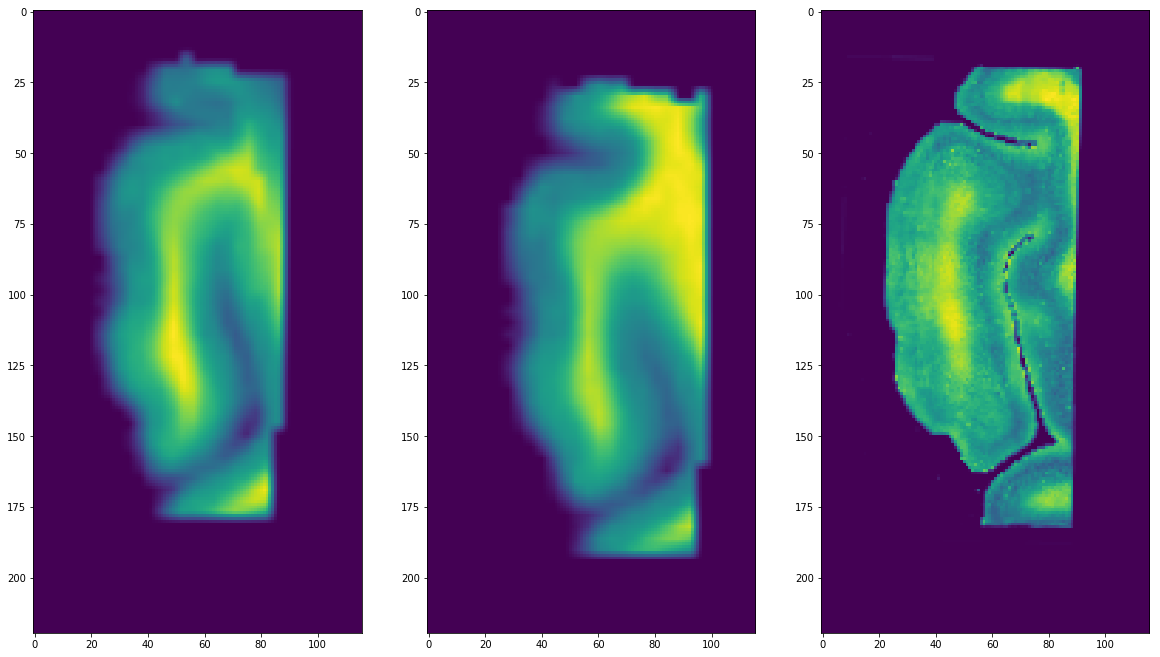

iter: 1, E= 1927.760, Eim_t= 1321.944, Eim_a= 605.799, ER_xy= 0.014, ER_t= 0.0025, ep_xy= 0.0000, ep_t= 0.0000.
iter: 2, E= 1927.687, Eim_t= 1321.945, Eim_a= 605.727, ER_xy= 0.014, ER_t= 0.0025, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 3, E= 1927.686, Eim_t= 1321.944, Eim_a= 605.725, ER_xy= 0.014, ER_t= 0.0025, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 4, E= 1927.611, Eim_t= 1321.945, Eim_a= 605.650, ER_xy= 0.014, ER_t= 0.0025, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 5, E= 1927.610, Eim_t= 1321.946, Eim_a= 605.648, ER_xy= 0.014, ER_t= 0.0025, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 6, E= 1927.532, Eim_t= 1321.946, Eim_a= 605.570, ER_xy= 0.014, ER_t= 0.0025, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 7, E= 1927.531, Eim_t= 1321.946, Eim_a= 605.569, ER_xy= 0.014, ER_t= 0.0025, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 8, E= 1927.451, Eim_t= 1321.947, Eim_a= 605.487, ER_xy= 0.014, ER_t= 0.0025, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 9, E= 1927.449

iter: 70, E= 1922.751, Eim_t= 1322.014, Eim_a= 600.721, ER_xy= 0.014, ER_t= 0.0025, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 71, E= 1922.747, Eim_t= 1322.014, Eim_a= 600.717, ER_xy= 0.014, ER_t= 0.0025, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 72, E= 1922.503, Eim_t= 1322.018, Eim_a= 600.469, ER_xy= 0.014, ER_t= 0.0025, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 73, E= 1922.500, Eim_t= 1322.018, Eim_a= 600.465, ER_xy= 0.014, ER_t= 0.0025, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 74, E= 1922.248, Eim_t= 1322.022, Eim_a= 600.210, ER_xy= 0.014, ER_t= 0.0025, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 75, E= 1922.244, Eim_t= 1322.023, Eim_a= 600.205, ER_xy= 0.014, ER_t= 0.0025, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 76, E= 1921.985, Eim_t= 1322.027, Eim_a= 599.942, ER_xy= 0.014, ER_t= 0.0025, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 77, E= 1921.981, Eim_t= 1322.027, Eim_a= 599.937, ER_xy= 0.014, ER_t= 0.0025, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.


iter: 62, E= 1619.933, ER= 0.000, EM= 1619.933, epd= 0.005, time= 0.03s.
iter: 63, E= 1619.887, ER= 0.000, EM= 1619.887, epd= 0.005, time= 0.03s.
iter: 64, E= 1619.841, ER= 0.000, EM= 1619.841, epd= 0.005, time= 0.03s.
iter: 65, E= 1619.795, ER= 0.000, EM= 1619.795, epd= 0.005, time= 0.03s.
iter: 66, E= 1619.749, ER= 0.000, EM= 1619.749, epd= 0.005, time= 0.03s.
iter: 67, E= 1619.703, ER= 0.000, EM= 1619.703, epd= 0.005, time= 0.03s.
iter: 68, E= 1619.658, ER= 0.000, EM= 1619.658, epd= 0.005, time= 0.03s.
iter: 69, E= 1619.613, ER= 0.000, EM= 1619.613, epd= 0.005, time= 0.03s.
iter: 70, E= 1619.567, ER= 0.000, EM= 1619.567, epd= 0.005, time= 0.03s.
iter: 71, E= 1619.522, ER= 0.000, EM= 1619.522, epd= 0.005, time= 0.03s.
iter: 72, E= 1619.477, ER= 0.000, EM= 1619.477, epd= 0.005, time= 0.03s.
iter: 73, E= 1619.432, ER= 0.000, EM= 1619.432, epd= 0.005, time= 0.03s.
iter: 74, E= 1619.388, ER= 0.000, EM= 1619.388, epd= 0.005, time= 0.03s.
iter: 75, E= 1619.344, ER= 0.000, EM= 1619.344, epd

iter: 174, E= 1615.578, ER= 0.000, EM= 1615.578, epd= 0.005, time= 0.03s.
iter: 175, E= 1615.544, ER= 0.000, EM= 1615.544, epd= 0.005, time= 0.03s.
iter: 176, E= 1615.511, ER= 0.000, EM= 1615.511, epd= 0.005, time= 0.03s.
iter: 177, E= 1615.478, ER= 0.000, EM= 1615.478, epd= 0.005, time= 0.03s.
iter: 178, E= 1615.445, ER= 0.000, EM= 1615.445, epd= 0.005, time= 0.03s.
iter: 179, E= 1615.412, ER= 0.000, EM= 1615.412, epd= 0.005, time= 0.03s.
iter: 180, E= 1615.379, ER= 0.000, EM= 1615.379, epd= 0.005, time= 0.03s.
iter: 181, E= 1615.347, ER= 0.000, EM= 1615.347, epd= 0.005, time= 0.03s.
iter: 182, E= 1615.314, ER= 0.000, EM= 1615.314, epd= 0.005, time= 0.03s.
iter: 183, E= 1615.282, ER= 0.000, EM= 1615.282, epd= 0.005, time= 0.03s.
iter: 184, E= 1615.249, ER= 0.000, EM= 1615.249, epd= 0.005, time= 0.03s.
iter: 185, E= 1615.217, ER= 0.000, EM= 1615.217, epd= 0.005, time= 0.03s.
iter: 186, E= 1615.185, ER= 0.000, EM= 1615.185, epd= 0.005, time= 0.03s.
iter: 187, E= 1615.153, ER= 0.000, EM=

iter: 286, E= 1612.264, ER= 0.000, EM= 1612.264, epd= 0.005, time= 0.03s.
iter: 287, E= 1612.239, ER= 0.000, EM= 1612.239, epd= 0.005, time= 0.03s.
iter: 288, E= 1612.213, ER= 0.000, EM= 1612.213, epd= 0.005, time= 0.03s.
iter: 289, E= 1612.188, ER= 0.000, EM= 1612.188, epd= 0.005, time= 0.03s.
iter: 290, E= 1612.163, ER= 0.000, EM= 1612.163, epd= 0.005, time= 0.03s.
iter: 291, E= 1612.137, ER= 0.000, EM= 1612.137, epd= 0.005, time= 0.03s.
iter: 292, E= 1612.113, ER= 0.000, EM= 1612.113, epd= 0.005, time= 0.03s.
iter: 293, E= 1612.088, ER= 0.000, EM= 1612.088, epd= 0.005, time= 0.03s.
iter: 294, E= 1612.063, ER= 0.000, EM= 1612.063, epd= 0.005, time= 0.03s.
iter: 295, E= 1612.038, ER= 0.000, EM= 1612.038, epd= 0.005, time= 0.03s.
iter: 296, E= 1612.014, ER= 0.000, EM= 1612.014, epd= 0.005, time= 0.03s.
iter: 297, E= 1611.989, ER= 0.000, EM= 1611.989, epd= 0.005, time= 0.03s.
iter: 298, E= 1611.965, ER= 0.000, EM= 1611.965, epd= 0.005, time= 0.03s.
iter: 299, E= 1611.941, ER= 0.000, EM=

iter: 398, E= 1609.924, ER= 0.000, EM= 1609.924, epd= 0.005, time= 0.03s.
iter: 399, E= 1609.908, ER= 0.000, EM= 1609.908, epd= 0.005, time= 0.03s.
iter: 400, E= 1609.891, ER= 0.000, EM= 1609.891, epd= 0.005, time= 0.03s.
iter: 401, E= 1609.876, ER= 0.000, EM= 1609.876, epd= 0.005, time= 0.03s.
iter: 402, E= 1609.865, ER= 0.000, EM= 1609.865, epd= 0.005, time= 0.03s.
iter: 403, E= 1609.857, ER= 0.000, EM= 1609.857, epd= 0.005, time= 0.03s.
iter: 404, E= 1609.851, ER= 0.000, EM= 1609.851, epd= 0.005, time= 0.03s.
iter: 405, E= 1609.848, ER= 0.000, EM= 1609.848, epd= 0.005, time= 0.03s.
iter: 406, E= 1609.845, ER= 0.000, EM= 1609.845, epd= 0.005, time= 0.03s.
iter: 407, E= 1609.843, ER= 0.000, EM= 1609.843, epd= 0.005, time= 0.03s.
iter: 408, E= 1609.842, ER= 0.000, EM= 1609.842, epd= 0.005, time= 0.03s.
iter: 409, E= 1609.841, ER= 0.000, EM= 1609.841, epd= 0.005, time= 0.03s.
iter: 410, E= 1609.840, ER= 0.000, EM= 1609.840, epd= 0.005, time= 0.03s.
iter: 411, E= 1609.840, ER= 0.000, EM=

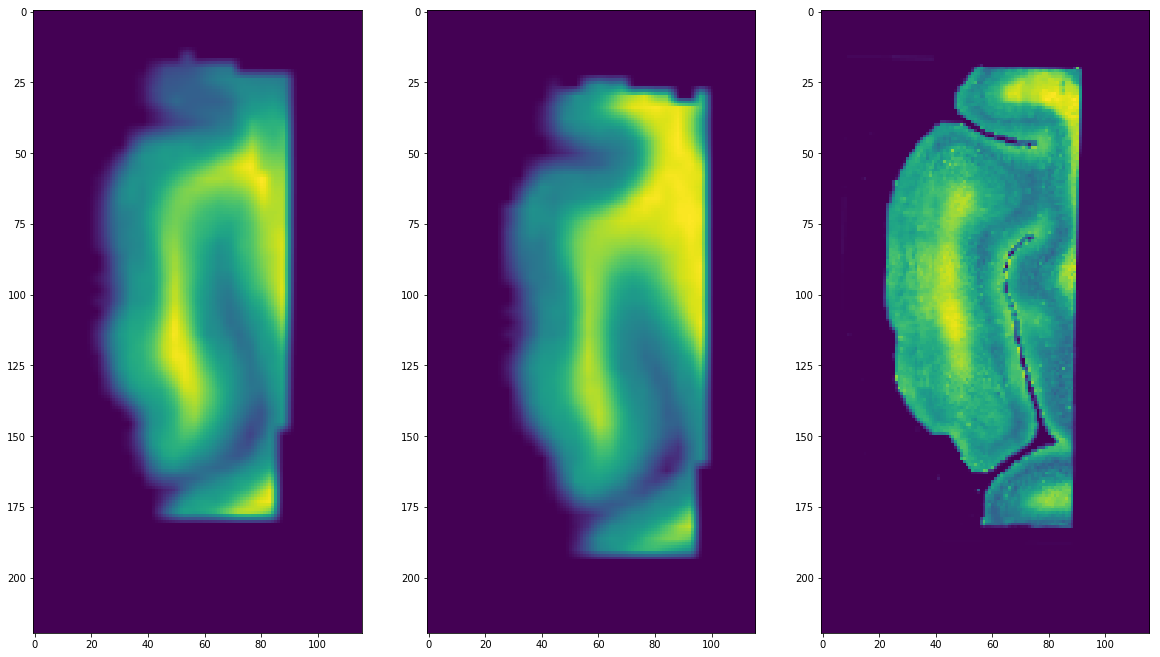

iter: 1, E= 1926.084, Eim_t= 1322.122, Eim_a= 603.945, ER_xy= 0.014, ER_t= 0.0025, ep_xy= 0.0000, ep_t= 0.0000.
iter: 2, E= 1924.309, Eim_t= 1322.167, Eim_a= 602.126, ER_xy= 0.014, ER_t= 0.0025, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 3, E= 1924.282, Eim_t= 1322.167, Eim_a= 602.099, ER_xy= 0.014, ER_t= 0.0025, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 4, E= 1922.531, Eim_t= 1322.208, Eim_a= 600.306, ER_xy= 0.014, ER_t= 0.0025, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 5, E= 1922.504, Eim_t= 1322.208, Eim_a= 600.279, ER_xy= 0.014, ER_t= 0.0025, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 6, E= 1920.791, Eim_t= 1322.255, Eim_a= 598.520, ER_xy= 0.014, ER_t= 0.0025, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 7, E= 1920.764, Eim_t= 1322.255, Eim_a= 598.493, ER_xy= 0.014, ER_t= 0.0025, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 8, E= 1919.101, Eim_t= 1322.313, Eim_a= 596.771, ER_xy= 0.014, ER_t= 0.0025, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 9, E= 1919.075

iter: 69, E= 1893.151, Eim_t= 1322.891, Eim_a= 570.243, ER_xy= 0.015, ER_t= 0.0026, ep_xy= 0.0001, ep_t= 0.0000, time= 0.02.
iter: 70, E= 1893.028, Eim_t= 1322.891, Eim_a= 570.120, ER_xy= 0.015, ER_t= 0.0026, ep_xy= 0.0001, ep_t= 0.0000, time= 0.02.
iter: 71, E= 1893.028, Eim_t= 1322.891, Eim_a= 570.120, ER_xy= 0.015, ER_t= 0.0026, ep_xy= 0.0001, ep_t= 0.0000, time= 0.02.
iter: 72, E= 1892.925, Eim_t= 1322.890, Eim_a= 570.018, ER_xy= 0.015, ER_t= 0.0026, ep_xy= 0.0001, ep_t= 0.0000, time= 0.02.
iter: 73, E= 1892.926, Eim_t= 1322.890, Eim_a= 570.018, ER_xy= 0.015, ER_t= 0.0026, ep_xy= 0.0001, ep_t= 0.0000, time= 0.02.
iter: 74, E= 1892.846, Eim_t= 1322.892, Eim_a= 569.936, ER_xy= 0.015, ER_t= 0.0026, ep_xy= 0.0001, ep_t= 0.0000, time= 0.02.
iter: 75, E= 1892.846, Eim_t= 1322.892, Eim_a= 569.937, ER_xy= 0.015, ER_t= 0.0026, ep_xy= 0.0001, ep_t= 0.0000, time= 0.02.
iter: 76, E= 1892.780, Eim_t= 1322.892, Eim_a= 569.870, ER_xy= 0.015, ER_t= 0.0026, ep_xy= 0.0002, ep_t= 0.0000, time= 0.02.


iter: 139, E= 1892.353, Eim_t= 1322.600, Eim_a= 569.734, ER_xy= 0.015, ER_t= 0.0026, ep_xy= 0.0005, ep_t= 0.0000, time= 0.02.
iter: 140, E= 1892.335, Eim_t= 1322.590, Eim_a= 569.728, ER_xy= 0.015, ER_t= 0.0026, ep_xy= 0.0005, ep_t= 0.0000, time= 0.02.
iter: 141, E= 1892.335, Eim_t= 1322.590, Eim_a= 569.728, ER_xy= 0.015, ER_t= 0.0026, ep_xy= 0.0005, ep_t= 0.0000, time= 0.02.
iter: 142, E= 1892.318, Eim_t= 1322.579, Eim_a= 569.721, ER_xy= 0.015, ER_t= 0.0026, ep_xy= 0.0006, ep_t= 0.0000, time= 0.02.
iter: 143, E= 1892.318, Eim_t= 1322.579, Eim_a= 569.721, ER_xy= 0.015, ER_t= 0.0026, ep_xy= 0.0006, ep_t= 0.0000, time= 0.02.
iter: 144, E= 1892.300, Eim_t= 1322.569, Eim_a= 569.714, ER_xy= 0.015, ER_t= 0.0026, ep_xy= 0.0006, ep_t= 0.0000, time= 0.02.
iter: 145, E= 1892.300, Eim_t= 1322.569, Eim_a= 569.714, ER_xy= 0.015, ER_t= 0.0026, ep_xy= 0.0006, ep_t= 0.0000, time= 0.02.
iter: 146, E= 1892.282, Eim_t= 1322.558, Eim_a= 569.706, ER_xy= 0.015, ER_t= 0.0026, ep_xy= 0.0006, ep_t= 0.0000, time

iter: 5, E= 1610.092, ER= 0.000, EM= 1610.092, epd= 0.005, time= 0.03s.
iter: 6, E= 1608.936, ER= 0.000, EM= 1608.936, epd= 0.005, time= 0.03s.
iter: 7, E= 1607.980, ER= 0.000, EM= 1607.980, epd= 0.005, time= 0.03s.
iter: 8, E= 1607.189, ER= 0.000, EM= 1607.189, epd= 0.005, time= 0.03s.
iter: 9, E= 1606.539, ER= 0.000, EM= 1606.539, epd= 0.005, time= 0.03s.
iter: 10, E= 1606.004, ER= 0.000, EM= 1606.004, epd= 0.005, time= 0.03s.
iter: 11, E= 1605.560, ER= 0.000, EM= 1605.560, epd= 0.005, time= 0.03s.
iter: 12, E= 1605.189, ER= 0.000, EM= 1605.189, epd= 0.005, time= 0.03s.
iter: 13, E= 1604.877, ER= 0.000, EM= 1604.877, epd= 0.005, time= 0.03s.
iter: 14, E= 1604.615, ER= 0.000, EM= 1604.615, epd= 0.005, time= 0.03s.
iter: 15, E= 1604.392, ER= 0.000, EM= 1604.392, epd= 0.005, time= 0.03s.
iter: 16, E= 1604.203, ER= 0.000, EM= 1604.203, epd= 0.005, time= 0.03s.
iter: 17, E= 1604.042, ER= 0.000, EM= 1604.042, epd= 0.005, time= 0.03s.
iter: 18, E= 1603.905, ER= 0.000, EM= 1603.905, epd= 0.0

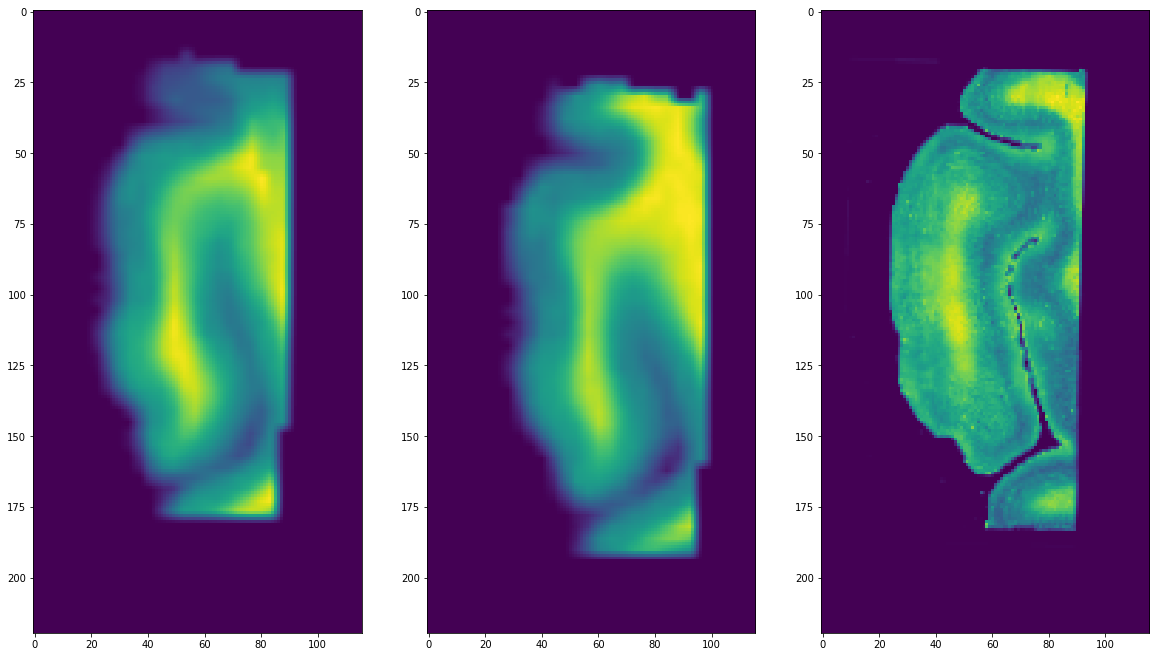

iter: 1, E= 1930.620, Eim_t= 1322.472, Eim_a= 608.131, ER_xy= 0.015, ER_t= 0.0026, ep_xy= 0.0007, ep_t= 0.0000.
iter: 2, E= 1912.049, Eim_t= 1323.366, Eim_a= 588.665, ER_xy= 0.016, ER_t= 0.0026, ep_xy= 0.0007, ep_t= 0.0000, time= 0.02.
iter: 3, E= 1912.049, Eim_t= 1323.366, Eim_a= 588.665, ER_xy= 0.016, ER_t= 0.0026, ep_xy= 0.0007, ep_t= 0.0000, time= 0.02.
iter: 4, E= 1907.563, Eim_t= 1322.755, Eim_a= 584.789, ER_xy= 0.016, ER_t= 0.0026, ep_xy= 0.0008, ep_t= 0.0000, time= 0.02.
iter: 5, E= 1907.563, Eim_t= 1322.755, Eim_a= 584.789, ER_xy= 0.016, ER_t= 0.0026, ep_xy= 0.0008, ep_t= 0.0000, time= 0.02.
iter: 6, E= 1906.809, Eim_t= 1322.823, Eim_a= 583.967, ER_xy= 0.016, ER_t= 0.0026, ep_xy= 0.0008, ep_t= 0.0000, time= 0.02.
iter: 7, E= 1906.809, Eim_t= 1322.823, Eim_a= 583.967, ER_xy= 0.016, ER_t= 0.0026, ep_xy= 0.0008, ep_t= 0.0000, time= 0.02.
iter: 8, E= 1905.799, Eim_t= 1322.309, Eim_a= 583.471, ER_xy= 0.016, ER_t= 0.0026, ep_xy= 0.0008, ep_t= 0.0000, time= 0.02.
iter: 9, E= 1905.798

iter: 70, E= 1905.038, Eim_t= 1321.594, Eim_a= 583.425, ER_xy= 0.016, ER_t= 0.0026, ep_xy= 0.0003, ep_t= 0.0000, time= 0.02.
iter: 71, E= 1905.038, Eim_t= 1321.594, Eim_a= 583.425, ER_xy= 0.016, ER_t= 0.0026, ep_xy= 0.0003, ep_t= 0.0000, time= 0.02.
iter: 72, E= 1905.037, Eim_t= 1321.594, Eim_a= 583.425, ER_xy= 0.016, ER_t= 0.0026, ep_xy= 0.0003, ep_t= 0.0000, time= 0.02.
iter: 73, E= 1905.037, Eim_t= 1321.594, Eim_a= 583.425, ER_xy= 0.016, ER_t= 0.0026, ep_xy= 0.0003, ep_t= 0.0000, time= 0.02.
iter: 74, E= 1905.037, Eim_t= 1321.594, Eim_a= 583.424, ER_xy= 0.016, ER_t= 0.0026, ep_xy= 0.0003, ep_t= 0.0000, time= 0.02.
iter: 75, E= 1905.037, Eim_t= 1321.594, Eim_a= 583.424, ER_xy= 0.016, ER_t= 0.0026, ep_xy= 0.0003, ep_t= 0.0000, time= 0.02.
iter: 76, E= 1905.037, Eim_t= 1321.595, Eim_a= 583.424, ER_xy= 0.016, ER_t= 0.0026, ep_xy= 0.0002, ep_t= 0.0000, time= 0.02.
iter: 77, E= 1905.037, Eim_t= 1321.595, Eim_a= 583.424, ER_xy= 0.016, ER_t= 0.0026, ep_xy= 0.0002, ep_t= 0.0000, time= 0.02.


iter: 140, E= 1905.037, Eim_t= 1321.597, Eim_a= 583.421, ER_xy= 0.016, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 141, E= 1905.037, Eim_t= 1321.597, Eim_a= 583.422, ER_xy= 0.016, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 142, E= 1905.037, Eim_t= 1321.597, Eim_a= 583.422, ER_xy= 0.016, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 143, E= 1905.037, Eim_t= 1321.597, Eim_a= 583.422, ER_xy= 0.016, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 144, E= 1905.037, Eim_t= 1321.597, Eim_a= 583.422, ER_xy= 0.016, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 145, E= 1905.037, Eim_t= 1321.597, Eim_a= 583.422, ER_xy= 0.016, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 146, E= 1905.037, Eim_t= 1321.597, Eim_a= 583.422, ER_xy= 0.016, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 147, E= 1905.037, Eim_t= 1321.597, Eim_a= 583.422, ER_xy= 0.016, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time

iter: 13, E= 1596.402, ER= 0.000, EM= 1596.402, epd= 0.005, time= 0.03s.
iter: 14, E= 1596.094, ER= 0.000, EM= 1596.094, epd= 0.005, time= 0.03s.
iter: 15, E= 1595.829, ER= 0.000, EM= 1595.829, epd= 0.005, time= 0.03s.
iter: 16, E= 1595.601, ER= 0.000, EM= 1595.601, epd= 0.005, time= 0.03s.
iter: 17, E= 1595.405, ER= 0.000, EM= 1595.405, epd= 0.005, time= 0.03s.
iter: 18, E= 1595.236, ER= 0.000, EM= 1595.236, epd= 0.005, time= 0.03s.
iter: 19, E= 1595.092, ER= 0.000, EM= 1595.092, epd= 0.005, time= 0.03s.
iter: 20, E= 1594.967, ER= 0.000, EM= 1594.967, epd= 0.005, time= 0.03s.
iter: 21, E= 1594.860, ER= 0.000, EM= 1594.860, epd= 0.005, time= 0.03s.
iter: 22, E= 1594.768, ER= 0.000, EM= 1594.768, epd= 0.005, time= 0.03s.
iter: 23, E= 1594.690, ER= 0.000, EM= 1594.690, epd= 0.005, time= 0.03s.
iter: 24, E= 1594.622, ER= 0.000, EM= 1594.622, epd= 0.005, time= 0.03s.
iter: 25, E= 1594.564, ER= 0.000, EM= 1594.564, epd= 0.005, time= 0.03s.
iter: 26, E= 1594.515, ER= 0.000, EM= 1594.515, epd

iter: 125, E= 1592.538, ER= 0.000, EM= 1592.538, epd= 0.005, time= 0.03s.
iter: 126, E= 1592.521, ER= 0.000, EM= 1592.521, epd= 0.005, time= 0.03s.
iter: 127, E= 1592.504, ER= 0.000, EM= 1592.504, epd= 0.005, time= 0.03s.
iter: 128, E= 1592.487, ER= 0.000, EM= 1592.487, epd= 0.005, time= 0.03s.
iter: 129, E= 1592.471, ER= 0.000, EM= 1592.471, epd= 0.005, time= 0.03s.
iter: 130, E= 1592.454, ER= 0.000, EM= 1592.454, epd= 0.005, time= 0.03s.
iter: 131, E= 1592.438, ER= 0.000, EM= 1592.438, epd= 0.005, time= 0.03s.
iter: 132, E= 1592.421, ER= 0.000, EM= 1592.421, epd= 0.005, time= 0.03s.
iter: 133, E= 1592.405, ER= 0.000, EM= 1592.405, epd= 0.005, time= 0.03s.
iter: 134, E= 1592.389, ER= 0.000, EM= 1592.389, epd= 0.005, time= 0.03s.
iter: 135, E= 1592.373, ER= 0.000, EM= 1592.373, epd= 0.005, time= 0.03s.
iter: 136, E= 1592.357, ER= 0.000, EM= 1592.357, epd= 0.005, time= 0.03s.
iter: 137, E= 1592.341, ER= 0.000, EM= 1592.341, epd= 0.005, time= 0.03s.
iter: 138, E= 1592.330, ER= 0.000, EM=

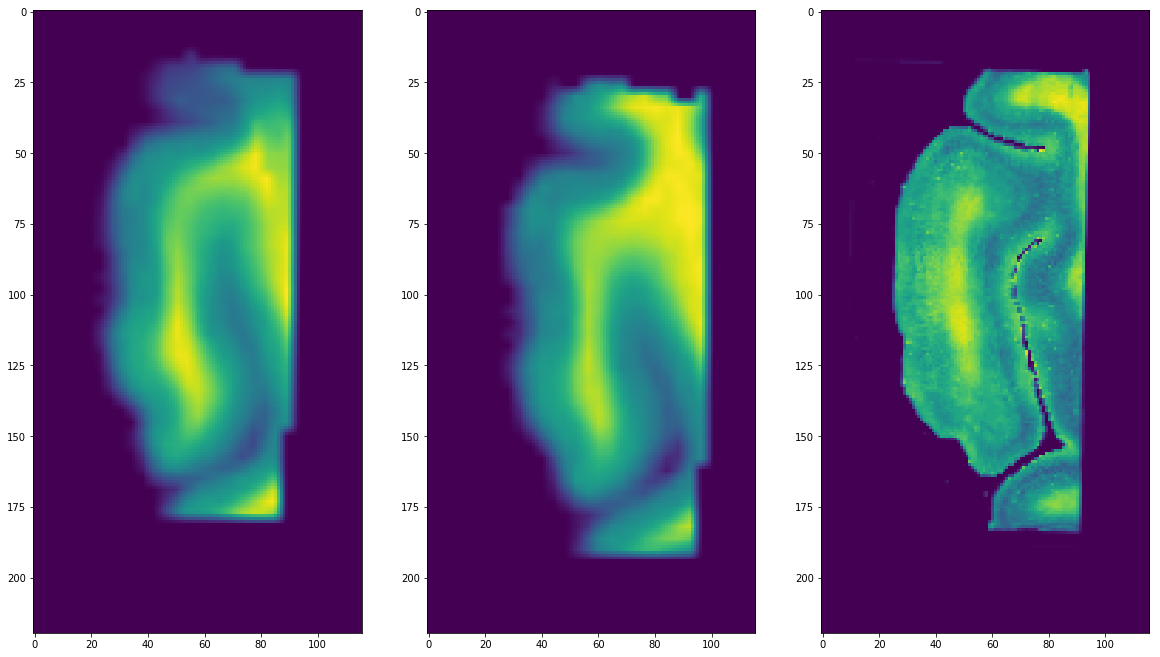

iter: 1, E= 1929.836, Eim_t= 1321.597, Eim_a= 608.220, ER_xy= 0.016, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000.
iter: 2, E= 1929.819, Eim_t= 1321.597, Eim_a= 608.203, ER_xy= 0.016, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 3, E= 1929.819, Eim_t= 1321.597, Eim_a= 608.203, ER_xy= 0.016, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 4, E= 1929.802, Eim_t= 1321.597, Eim_a= 608.186, ER_xy= 0.016, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 5, E= 1929.802, Eim_t= 1321.596, Eim_a= 608.186, ER_xy= 0.016, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 6, E= 1929.784, Eim_t= 1321.596, Eim_a= 608.168, ER_xy= 0.016, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 7, E= 1929.784, Eim_t= 1321.596, Eim_a= 608.168, ER_xy= 0.016, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 8, E= 1929.765, Eim_t= 1321.596, Eim_a= 608.150, ER_xy= 0.016, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 9, E= 1929.765

iter: 70, E= 1928.650, Eim_t= 1321.590, Eim_a= 607.040, ER_xy= 0.016, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 71, E= 1928.650, Eim_t= 1321.590, Eim_a= 607.040, ER_xy= 0.016, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 72, E= 1928.588, Eim_t= 1321.590, Eim_a= 606.979, ER_xy= 0.016, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 73, E= 1928.588, Eim_t= 1321.590, Eim_a= 606.979, ER_xy= 0.016, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 74, E= 1928.524, Eim_t= 1321.589, Eim_a= 606.915, ER_xy= 0.016, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 75, E= 1928.524, Eim_t= 1321.589, Eim_a= 606.915, ER_xy= 0.016, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 76, E= 1928.457, Eim_t= 1321.589, Eim_a= 606.849, ER_xy= 0.016, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 77, E= 1928.457, Eim_t= 1321.589, Eim_a= 606.849, ER_xy= 0.016, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.


iter: 140, E= 1924.573, Eim_t= 1321.594, Eim_a= 602.959, ER_xy= 0.017, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 141, E= 1924.573, Eim_t= 1321.594, Eim_a= 602.959, ER_xy= 0.017, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 142, E= 1924.378, Eim_t= 1321.595, Eim_a= 602.764, ER_xy= 0.017, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 143, E= 1924.378, Eim_t= 1321.595, Eim_a= 602.764, ER_xy= 0.017, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 144, E= 1924.178, Eim_t= 1321.596, Eim_a= 602.563, ER_xy= 0.017, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 145, E= 1924.178, Eim_t= 1321.596, Eim_a= 602.563, ER_xy= 0.017, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 146, E= 1923.974, Eim_t= 1321.597, Eim_a= 602.357, ER_xy= 0.017, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 147, E= 1923.974, Eim_t= 1321.597, Eim_a= 602.357, ER_xy= 0.017, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time

iter: 13, E= 1591.072, ER= 0.000, EM= 1591.072, epd= 0.005, time= 0.03s.
iter: 14, E= 1591.025, ER= 0.000, EM= 1591.025, epd= 0.005, time= 0.03s.
iter: 15, E= 1590.982, ER= 0.000, EM= 1590.982, epd= 0.005, time= 0.03s.
iter: 16, E= 1590.943, ER= 0.000, EM= 1590.943, epd= 0.005, time= 0.03s.
iter: 17, E= 1590.906, ER= 0.000, EM= 1590.906, epd= 0.005, time= 0.03s.
iter: 18, E= 1590.872, ER= 0.000, EM= 1590.872, epd= 0.005, time= 0.03s.
iter: 19, E= 1590.839, ER= 0.000, EM= 1590.839, epd= 0.005, time= 0.03s.
iter: 20, E= 1590.809, ER= 0.000, EM= 1590.809, epd= 0.005, time= 0.03s.
iter: 21, E= 1590.779, ER= 0.000, EM= 1590.779, epd= 0.005, time= 0.03s.
iter: 22, E= 1590.751, ER= 0.000, EM= 1590.751, epd= 0.005, time= 0.03s.
iter: 23, E= 1590.724, ER= 0.000, EM= 1590.724, epd= 0.005, time= 0.03s.
iter: 24, E= 1590.697, ER= 0.000, EM= 1590.697, epd= 0.005, time= 0.03s.
iter: 25, E= 1590.672, ER= 0.000, EM= 1590.672, epd= 0.005, time= 0.03s.
iter: 26, E= 1590.647, ER= 0.000, EM= 1590.647, epd

iter: 125, E= 1589.161, ER= 0.000, EM= 1589.161, epd= 0.005, time= 0.03s.
Early termination: Energy change threshold reached.
Total elapsed runtime: 3.62 seconds.


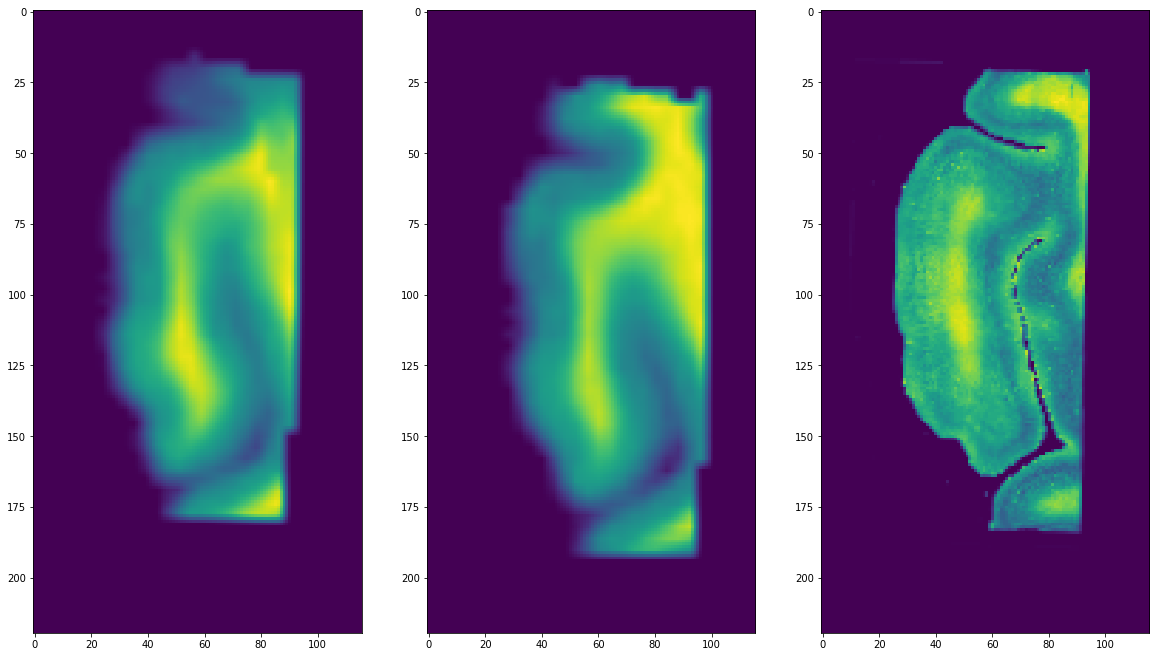

iter: 1, E= 1929.321, Eim_t= 1321.764, Eim_a= 607.537, ER_xy= 0.017, ER_t= 0.0026, ep_xy= 0.0001, ep_t= 0.0000.
iter: 2, E= 1926.836, Eim_t= 1321.905, Eim_a= 604.911, ER_xy= 0.017, ER_t= 0.0026, ep_xy= 0.0001, ep_t= 0.0000, time= 0.02.
iter: 3, E= 1926.837, Eim_t= 1321.905, Eim_a= 604.911, ER_xy= 0.017, ER_t= 0.0026, ep_xy= 0.0001, ep_t= 0.0000, time= 0.02.
iter: 4, E= 1924.607, Eim_t= 1322.033, Eim_a= 602.554, ER_xy= 0.017, ER_t= 0.0026, ep_xy= 0.0001, ep_t= 0.0000, time= 0.02.
iter: 5, E= 1924.607, Eim_t= 1322.033, Eim_a= 602.554, ER_xy= 0.017, ER_t= 0.0026, ep_xy= 0.0001, ep_t= 0.0000, time= 0.02.
iter: 6, E= 1922.612, Eim_t= 1322.137, Eim_a= 600.455, ER_xy= 0.017, ER_t= 0.0026, ep_xy= 0.0001, ep_t= 0.0000, time= 0.02.
iter: 7, E= 1922.612, Eim_t= 1322.137, Eim_a= 600.455, ER_xy= 0.017, ER_t= 0.0026, ep_xy= 0.0001, ep_t= 0.0000, time= 0.02.
iter: 8, E= 1920.829, Eim_t= 1322.213, Eim_a= 598.596, ER_xy= 0.017, ER_t= 0.0026, ep_xy= 0.0001, ep_t= 0.0000, time= 0.02.
iter: 9, E= 1920.829

iter: 70, E= 1908.865, Eim_t= 1321.207, Eim_a= 587.637, ER_xy= 0.018, ER_t= 0.0026, ep_xy= 0.0004, ep_t= 0.0000, time= 0.02.
iter: 71, E= 1908.865, Eim_t= 1321.207, Eim_a= 587.637, ER_xy= 0.018, ER_t= 0.0026, ep_xy= 0.0004, ep_t= 0.0000, time= 0.02.
iter: 72, E= 1908.862, Eim_t= 1321.197, Eim_a= 587.644, ER_xy= 0.018, ER_t= 0.0026, ep_xy= 0.0004, ep_t= 0.0000, time= 0.02.
iter: 73, E= 1908.862, Eim_t= 1321.197, Eim_a= 587.644, ER_xy= 0.018, ER_t= 0.0026, ep_xy= 0.0004, ep_t= 0.0000, time= 0.02.
iter: 74, E= 1908.859, Eim_t= 1321.188, Eim_a= 587.650, ER_xy= 0.018, ER_t= 0.0026, ep_xy= 0.0004, ep_t= 0.0000, time= 0.02.
iter: 75, E= 1908.859, Eim_t= 1321.188, Eim_a= 587.650, ER_xy= 0.018, ER_t= 0.0026, ep_xy= 0.0004, ep_t= 0.0000, time= 0.02.
iter: 76, E= 1908.857, Eim_t= 1321.180, Eim_a= 587.656, ER_xy= 0.018, ER_t= 0.0026, ep_xy= 0.0004, ep_t= 0.0000, time= 0.02.
iter: 77, E= 1908.857, Eim_t= 1321.180, Eim_a= 587.656, ER_xy= 0.018, ER_t= 0.0026, ep_xy= 0.0004, ep_t= 0.0000, time= 0.02.


iter: 140, E= 1908.767, Eim_t= 1321.125, Eim_a= 587.620, ER_xy= 0.019, ER_t= 0.0026, ep_xy= 0.0004, ep_t= 0.0000, time= 0.02.
iter: 141, E= 1908.767, Eim_t= 1321.125, Eim_a= 587.620, ER_xy= 0.019, ER_t= 0.0026, ep_xy= 0.0004, ep_t= 0.0000, time= 0.02.
iter: 142, E= 1908.767, Eim_t= 1321.127, Eim_a= 587.619, ER_xy= 0.019, ER_t= 0.0026, ep_xy= 0.0002, ep_t= 0.0000, time= 0.02.
iter: 143, E= 1908.767, Eim_t= 1321.127, Eim_a= 587.619, ER_xy= 0.019, ER_t= 0.0026, ep_xy= 0.0002, ep_t= 0.0000, time= 0.02.
iter: 144, E= 1908.767, Eim_t= 1321.127, Eim_a= 587.619, ER_xy= 0.019, ER_t= 0.0026, ep_xy= 0.0002, ep_t= 0.0000, time= 0.02.
iter: 145, E= 1908.767, Eim_t= 1321.127, Eim_a= 587.619, ER_xy= 0.019, ER_t= 0.0026, ep_xy= 0.0002, ep_t= 0.0000, time= 0.02.
iter: 146, E= 1908.767, Eim_t= 1321.128, Eim_a= 587.619, ER_xy= 0.019, ER_t= 0.0026, ep_xy= 0.0002, ep_t= 0.0000, time= 0.02.
iter: 147, E= 1908.767, Eim_t= 1321.128, Eim_a= 587.619, ER_xy= 0.019, ER_t= 0.0026, ep_xy= 0.0002, ep_t= 0.0000, time

iter: 13, E= 1575.215, ER= 0.000, EM= 1575.215, epd= 0.005, time= 0.03s.
iter: 14, E= 1574.940, ER= 0.000, EM= 1574.940, epd= 0.005, time= 0.03s.
iter: 15, E= 1574.707, ER= 0.000, EM= 1574.707, epd= 0.005, time= 0.03s.
iter: 16, E= 1574.507, ER= 0.000, EM= 1574.507, epd= 0.005, time= 0.03s.
iter: 17, E= 1574.338, ER= 0.000, EM= 1574.338, epd= 0.005, time= 0.03s.
iter: 18, E= 1574.194, ER= 0.000, EM= 1574.194, epd= 0.005, time= 0.03s.
iter: 19, E= 1574.069, ER= 0.000, EM= 1574.069, epd= 0.005, time= 0.03s.
iter: 20, E= 1573.962, ER= 0.000, EM= 1573.962, epd= 0.005, time= 0.03s.
iter: 21, E= 1573.870, ER= 0.000, EM= 1573.870, epd= 0.005, time= 0.03s.
iter: 22, E= 1573.791, ER= 0.000, EM= 1573.791, epd= 0.005, time= 0.03s.
iter: 23, E= 1573.724, ER= 0.000, EM= 1573.724, epd= 0.005, time= 0.03s.
iter: 24, E= 1573.666, ER= 0.000, EM= 1573.666, epd= 0.005, time= 0.03s.
iter: 25, E= 1573.616, ER= 0.000, EM= 1573.616, epd= 0.005, time= 0.03s.
iter: 26, E= 1573.574, ER= 0.000, EM= 1573.574, epd

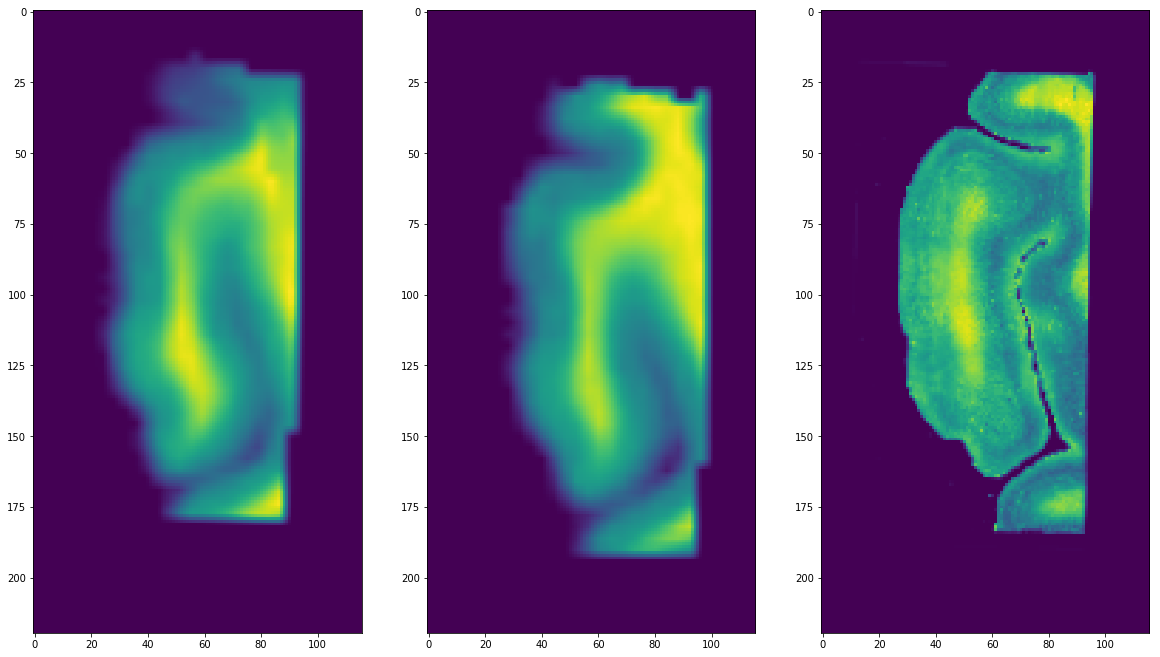

iter: 1, E= 1937.538, Eim_t= 1321.130, Eim_a= 616.387, ER_xy= 0.019, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000.
iter: 2, E= 1936.951, Eim_t= 1321.152, Eim_a= 615.777, ER_xy= 0.019, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 3, E= 1936.951, Eim_t= 1321.152, Eim_a= 615.777, ER_xy= 0.019, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 4, E= 1936.367, Eim_t= 1321.179, Eim_a= 615.166, ER_xy= 0.019, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 5, E= 1936.367, Eim_t= 1321.179, Eim_a= 615.166, ER_xy= 0.019, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 6, E= 1935.781, Eim_t= 1321.207, Eim_a= 614.552, ER_xy= 0.019, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 7, E= 1935.781, Eim_t= 1321.207, Eim_a= 614.552, ER_xy= 0.019, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 8, E= 1935.196, Eim_t= 1321.236, Eim_a= 613.938, ER_xy= 0.019, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 9, E= 1935.196

iter: 70, E= 1920.610, Eim_t= 1321.507, Eim_a= 599.080, ER_xy= 0.020, ER_t= 0.0026, ep_xy= 0.0001, ep_t= 0.0000, time= 0.02.
iter: 71, E= 1920.610, Eim_t= 1321.507, Eim_a= 599.080, ER_xy= 0.020, ER_t= 0.0026, ep_xy= 0.0001, ep_t= 0.0000, time= 0.02.
iter: 72, E= 1920.407, Eim_t= 1321.514, Eim_a= 598.871, ER_xy= 0.020, ER_t= 0.0026, ep_xy= 0.0001, ep_t= 0.0000, time= 0.02.
iter: 73, E= 1920.407, Eim_t= 1321.514, Eim_a= 598.871, ER_xy= 0.020, ER_t= 0.0026, ep_xy= 0.0001, ep_t= 0.0000, time= 0.02.
iter: 74, E= 1920.225, Eim_t= 1321.522, Eim_a= 598.680, ER_xy= 0.020, ER_t= 0.0026, ep_xy= 0.0001, ep_t= 0.0000, time= 0.02.
iter: 75, E= 1920.225, Eim_t= 1321.522, Eim_a= 598.680, ER_xy= 0.020, ER_t= 0.0026, ep_xy= 0.0001, ep_t= 0.0000, time= 0.02.
iter: 76, E= 1920.060, Eim_t= 1321.532, Eim_a= 598.506, ER_xy= 0.020, ER_t= 0.0026, ep_xy= 0.0001, ep_t= 0.0000, time= 0.02.
iter: 77, E= 1920.060, Eim_t= 1321.532, Eim_a= 598.506, ER_xy= 0.020, ER_t= 0.0026, ep_xy= 0.0001, ep_t= 0.0000, time= 0.02.


iter: 140, E= 1918.972, Eim_t= 1321.560, Eim_a= 597.389, ER_xy= 0.021, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 141, E= 1918.972, Eim_t= 1321.560, Eim_a= 597.389, ER_xy= 0.021, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 142, E= 1918.973, Eim_t= 1321.560, Eim_a= 597.389, ER_xy= 0.021, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 143, E= 1918.973, Eim_t= 1321.560, Eim_a= 597.389, ER_xy= 0.021, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 144, E= 1918.973, Eim_t= 1321.560, Eim_a= 597.389, ER_xy= 0.021, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 145, E= 1918.973, Eim_t= 1321.560, Eim_a= 597.389, ER_xy= 0.021, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 146, E= 1918.973, Eim_t= 1321.560, Eim_a= 597.390, ER_xy= 0.021, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 147, E= 1918.973, Eim_t= 1321.560, Eim_a= 597.390, ER_xy= 0.021, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time

iter: 210, E= 1918.973, Eim_t= 1321.560, Eim_a= 597.390, ER_xy= 0.021, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 211, E= 1918.973, Eim_t= 1321.560, Eim_a= 597.390, ER_xy= 0.021, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 212, E= 1918.973, Eim_t= 1321.560, Eim_a= 597.390, ER_xy= 0.021, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 213, E= 1918.973, Eim_t= 1321.560, Eim_a= 597.390, ER_xy= 0.021, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 214, E= 1918.973, Eim_t= 1321.560, Eim_a= 597.390, ER_xy= 0.021, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 215, E= 1918.973, Eim_t= 1321.560, Eim_a= 597.390, ER_xy= 0.021, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 216, E= 1918.973, Eim_t= 1321.560, Eim_a= 597.390, ER_xy= 0.021, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 217, E= 1918.973, Eim_t= 1321.560, Eim_a= 597.390, ER_xy= 0.021, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time

iter: 280, E= 1918.973, Eim_t= 1321.560, Eim_a= 597.390, ER_xy= 0.021, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 281, E= 1918.973, Eim_t= 1321.560, Eim_a= 597.390, ER_xy= 0.021, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 282, E= 1918.973, Eim_t= 1321.560, Eim_a= 597.390, ER_xy= 0.021, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 283, E= 1918.973, Eim_t= 1321.560, Eim_a= 597.390, ER_xy= 0.021, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 284, E= 1918.973, Eim_t= 1321.560, Eim_a= 597.390, ER_xy= 0.021, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 285, E= 1918.973, Eim_t= 1321.560, Eim_a= 597.390, ER_xy= 0.021, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 286, E= 1918.973, Eim_t= 1321.560, Eim_a= 597.390, ER_xy= 0.021, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 287, E= 1918.973, Eim_t= 1321.560, Eim_a= 597.390, ER_xy= 0.021, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time

iter: 350, E= 1918.973, Eim_t= 1321.560, Eim_a= 597.390, ER_xy= 0.021, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 351, E= 1918.973, Eim_t= 1321.560, Eim_a= 597.390, ER_xy= 0.021, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 352, E= 1918.973, Eim_t= 1321.560, Eim_a= 597.390, ER_xy= 0.021, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 353, E= 1918.973, Eim_t= 1321.560, Eim_a= 597.390, ER_xy= 0.021, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 354, E= 1918.973, Eim_t= 1321.560, Eim_a= 597.390, ER_xy= 0.021, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 355, E= 1918.973, Eim_t= 1321.560, Eim_a= 597.390, ER_xy= 0.021, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 356, E= 1918.973, Eim_t= 1321.560, Eim_a= 597.390, ER_xy= 0.021, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 357, E= 1918.973, Eim_t= 1321.560, Eim_a= 597.390, ER_xy= 0.021, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time

iter: 420, E= 1918.973, Eim_t= 1321.560, Eim_a= 597.390, ER_xy= 0.021, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 421, E= 1918.973, Eim_t= 1321.560, Eim_a= 597.390, ER_xy= 0.021, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 422, E= 1918.973, Eim_t= 1321.560, Eim_a= 597.390, ER_xy= 0.021, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 423, E= 1918.973, Eim_t= 1321.560, Eim_a= 597.390, ER_xy= 0.021, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 424, E= 1918.973, Eim_t= 1321.560, Eim_a= 597.390, ER_xy= 0.021, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 425, E= 1918.973, Eim_t= 1321.560, Eim_a= 597.390, ER_xy= 0.021, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 426, E= 1918.973, Eim_t= 1321.560, Eim_a= 597.390, ER_xy= 0.021, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 427, E= 1918.973, Eim_t= 1321.560, Eim_a= 597.390, ER_xy= 0.021, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time

iter: 490, E= 1918.973, Eim_t= 1321.560, Eim_a= 597.390, ER_xy= 0.021, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 491, E= 1918.973, Eim_t= 1321.560, Eim_a= 597.390, ER_xy= 0.021, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 492, E= 1918.973, Eim_t= 1321.560, Eim_a= 597.390, ER_xy= 0.021, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 493, E= 1918.973, Eim_t= 1321.560, Eim_a= 597.390, ER_xy= 0.021, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 494, E= 1918.973, Eim_t= 1321.560, Eim_a= 597.390, ER_xy= 0.021, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 495, E= 1918.973, Eim_t= 1321.560, Eim_a= 597.390, ER_xy= 0.021, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 496, E= 1918.973, Eim_t= 1321.560, Eim_a= 597.390, ER_xy= 0.021, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 497, E= 1918.973, Eim_t= 1321.560, Eim_a= 597.390, ER_xy= 0.021, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time

iter: 560, E= 1918.973, Eim_t= 1321.560, Eim_a= 597.390, ER_xy= 0.021, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 561, E= 1918.973, Eim_t= 1321.560, Eim_a= 597.390, ER_xy= 0.021, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 562, E= 1918.973, Eim_t= 1321.560, Eim_a= 597.390, ER_xy= 0.021, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 563, E= 1918.973, Eim_t= 1321.560, Eim_a= 597.390, ER_xy= 0.021, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 564, E= 1918.973, Eim_t= 1321.560, Eim_a= 597.390, ER_xy= 0.021, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 565, E= 1918.973, Eim_t= 1321.560, Eim_a= 597.390, ER_xy= 0.021, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 566, E= 1918.973, Eim_t= 1321.560, Eim_a= 597.390, ER_xy= 0.021, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 567, E= 1918.973, Eim_t= 1321.560, Eim_a= 597.390, ER_xy= 0.021, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time

iter: 630, E= 1918.973, Eim_t= 1321.560, Eim_a= 597.390, ER_xy= 0.021, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 631, E= 1918.973, Eim_t= 1321.560, Eim_a= 597.390, ER_xy= 0.021, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 632, E= 1918.973, Eim_t= 1321.560, Eim_a= 597.390, ER_xy= 0.021, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 633, E= 1918.973, Eim_t= 1321.560, Eim_a= 597.390, ER_xy= 0.021, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 634, E= 1918.973, Eim_t= 1321.560, Eim_a= 597.390, ER_xy= 0.021, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 635, E= 1918.973, Eim_t= 1321.560, Eim_a= 597.390, ER_xy= 0.021, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 636, E= 1918.973, Eim_t= 1321.560, Eim_a= 597.390, ER_xy= 0.021, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 637, E= 1918.973, Eim_t= 1321.560, Eim_a= 597.390, ER_xy= 0.021, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time

iter: 700, E= 1918.973, Eim_t= 1321.560, Eim_a= 597.390, ER_xy= 0.021, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 701, E= 1918.973, Eim_t= 1321.560, Eim_a= 597.390, ER_xy= 0.021, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 702, E= 1918.973, Eim_t= 1321.560, Eim_a= 597.390, ER_xy= 0.021, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 703, E= 1918.973, Eim_t= 1321.560, Eim_a= 597.390, ER_xy= 0.021, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 704, E= 1918.973, Eim_t= 1321.560, Eim_a= 597.390, ER_xy= 0.021, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 705, E= 1918.973, Eim_t= 1321.560, Eim_a= 597.390, ER_xy= 0.021, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 706, E= 1918.973, Eim_t= 1321.560, Eim_a= 597.390, ER_xy= 0.021, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 707, E= 1918.973, Eim_t= 1321.560, Eim_a= 597.390, ER_xy= 0.021, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time

iter: 770, E= 1918.973, Eim_t= 1321.560, Eim_a= 597.390, ER_xy= 0.021, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 771, E= 1918.973, Eim_t= 1321.560, Eim_a= 597.390, ER_xy= 0.021, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 772, E= 1918.973, Eim_t= 1321.560, Eim_a= 597.390, ER_xy= 0.021, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 773, E= 1918.973, Eim_t= 1321.560, Eim_a= 597.390, ER_xy= 0.021, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 774, E= 1918.973, Eim_t= 1321.560, Eim_a= 597.390, ER_xy= 0.021, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 775, E= 1918.973, Eim_t= 1321.560, Eim_a= 597.390, ER_xy= 0.021, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 776, E= 1918.973, Eim_t= 1321.560, Eim_a= 597.390, ER_xy= 0.021, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time= 0.02.
iter: 777, E= 1918.973, Eim_t= 1321.560, Eim_a= 597.390, ER_xy= 0.021, ER_t= 0.0026, ep_xy= 0.0000, ep_t= 0.0000, time

iter: 62, E= 1566.448, ER= 0.000, EM= 1566.448, epd= 0.005, time= 0.03s.
iter: 63, E= 1566.428, ER= 0.000, EM= 1566.428, epd= 0.005, time= 0.03s.
iter: 64, E= 1566.408, ER= 0.000, EM= 1566.408, epd= 0.005, time= 0.03s.
iter: 65, E= 1566.388, ER= 0.000, EM= 1566.388, epd= 0.005, time= 0.03s.
iter: 66, E= 1566.367, ER= 0.000, EM= 1566.367, epd= 0.005, time= 0.03s.
iter: 67, E= 1566.347, ER= 0.000, EM= 1566.347, epd= 0.005, time= 0.03s.
iter: 68, E= 1566.327, ER= 0.000, EM= 1566.327, epd= 0.005, time= 0.03s.
iter: 69, E= 1566.307, ER= 0.000, EM= 1566.307, epd= 0.005, time= 0.03s.
iter: 70, E= 1566.287, ER= 0.000, EM= 1566.287, epd= 0.005, time= 0.03s.
iter: 71, E= 1566.267, ER= 0.000, EM= 1566.267, epd= 0.005, time= 0.03s.
iter: 72, E= 1566.246, ER= 0.000, EM= 1566.246, epd= 0.005, time= 0.03s.
iter: 73, E= 1566.226, ER= 0.000, EM= 1566.226, epd= 0.005, time= 0.03s.
iter: 74, E= 1566.206, ER= 0.000, EM= 1566.206, epd= 0.005, time= 0.03s.
iter: 75, E= 1566.187, ER= 0.000, EM= 1566.187, epd

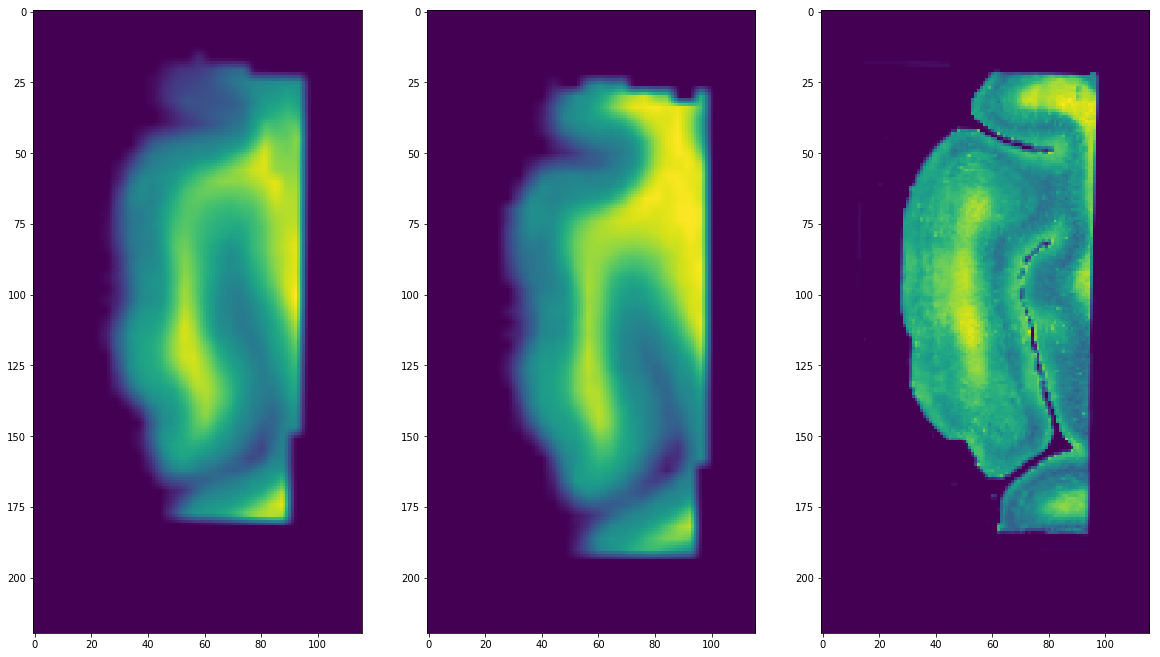

In [28]:
if lddmm.params['gpu_number'] is None:
    device = 'cpu'
elif lddmm.params['gpu_number'] == 1:
    device = 'cuda:1'
elif lddmm.params['gpu_number'] == 0:
    device = 'cuda:0'
    
    
#origJ = lddmm.J[0].clone()
epsilonxy = 4e-7
epsilontheta=2e-7
a = None
b = None
theta = None
niter = 500

# loop
nepochs = 8
for i in range(1,nepochs):
    if i == 1:
        niter = 600
    elif i < 3:
        niter = 100
    elif i == 7:
        niter = 800
    else:
        niter = 200
    
    
    # resample the mri image
    mri_translated_rigid = (lddmm.applyThisTransform(mri_translated))[0][-1].cpu().numpy()
    
    # rigidly align target to the mri
    a,b,theta,outtarget,epsilonxy,epsilontheta = lddmm.sa(torch.tensor(target_resample_arr).type(torch.FloatTensor).to(device=device),torch.tensor(mri_translated_rigid).type(torch.FloatTensor).to(device=device),niter=niter,dim=2,norm=0,missingslices=missingslices,sigma_atlas=38.35,sigma_target=50.0,a=a,b=b,theta=theta,nx=list(target_resample_arr.shape),dx=output_spacing,epsilonxy=epsilonxy*4, epsilontheta=epsilontheta*4, sigma_target_radius=1, sigma_atlas_radius=1)
    lddmm.setParams('a',4)
    outtarget = lddmm.applySA(torch.tensor(target_resample_arr).type(torch.FloatTensor).to(device=device), a, b, theta, dim=2,nx=list(target_resample_arr.shape),dx=output_spacing).cpu().numpy().astype(np.float32)

    # update the target image and continue affine alignment of the mri to the histology stack
    lddmm.J[0] = torch.tensor(outtarget).type(torch.FloatTensor).to(device=device)
    lddmm.setParams('epsilonL',1e-5)
    lddmm.setParams('epsilonT',2e-5)
#     lddmm.setParams('energy_fraction',0.8) early stopping parameter
    lddmm.setParams('energy_fraction_from',len(lddmm.EAll)-1)
    lddmm.run()
    
    plt.figure()
    plt.subplot(1,3,1)
    plt.imshow(mri_translated_rigid[:,:,4])
    plt.subplot(1,3,2) 
    plt.imshow(mri_translated[:,:,4])
    plt.subplot(1,3,3) 
    plt.imshow(outtarget[:,:,4])
    plt.show()
    
    
        



# nepochs = 8

# # loop
# for i in range(1,nepochs):
#     if i == 1:
#         niter = 600
#     elif i < 3:
#         niter = 100
#     elif i == 7:
#         niter = 800
#     else:
#         niter = 200
    
#     a,b,theta,outtarget,epsilonxy,epsilontheta = lddmm.sa(torch.tensor(target_image).type(torch.FloatTensor).cuda(),torch.tensor(deformed_mri).type(torch.FloatTensor).cuda(),niter=niter,dim=1,norm=0,missingslices=missingslices,sigma_atlas=4.0,sigma_target=50.0,a=a,b=b,theta=theta,nx=list(target_image.shape),dx=[0.08,0.04,0.08],epsilonxy=epsilonxy*4, epsilontheta=epsilontheta*4)
#     outtarget = torch.transpose(lddmm.applySA(torch.tensor(target_image).type(torch.FloatTensor).cuda(), a, b, theta, dim=1,nx=list(target_image.shape),dx=[0.08,0.04,0.08]),2,1).cpu().numpy().astype(np.float32)
#     lddmm.setParams('energy_fraction_from',len(lddmm.EAll)-1)
    
#     if i < nepochs:
#         lddmm.J[0] = torch.tensor(outtarget).type(torch.FloatTensor).cuda()
#         lddmm.setParams('niter',40)
#         lddmm.run()
    
#     # resample the mri image
#     deformed_mri = (lddmm.applyThisTransform(mri_adjusted))[0][-1].cpu().numpy()

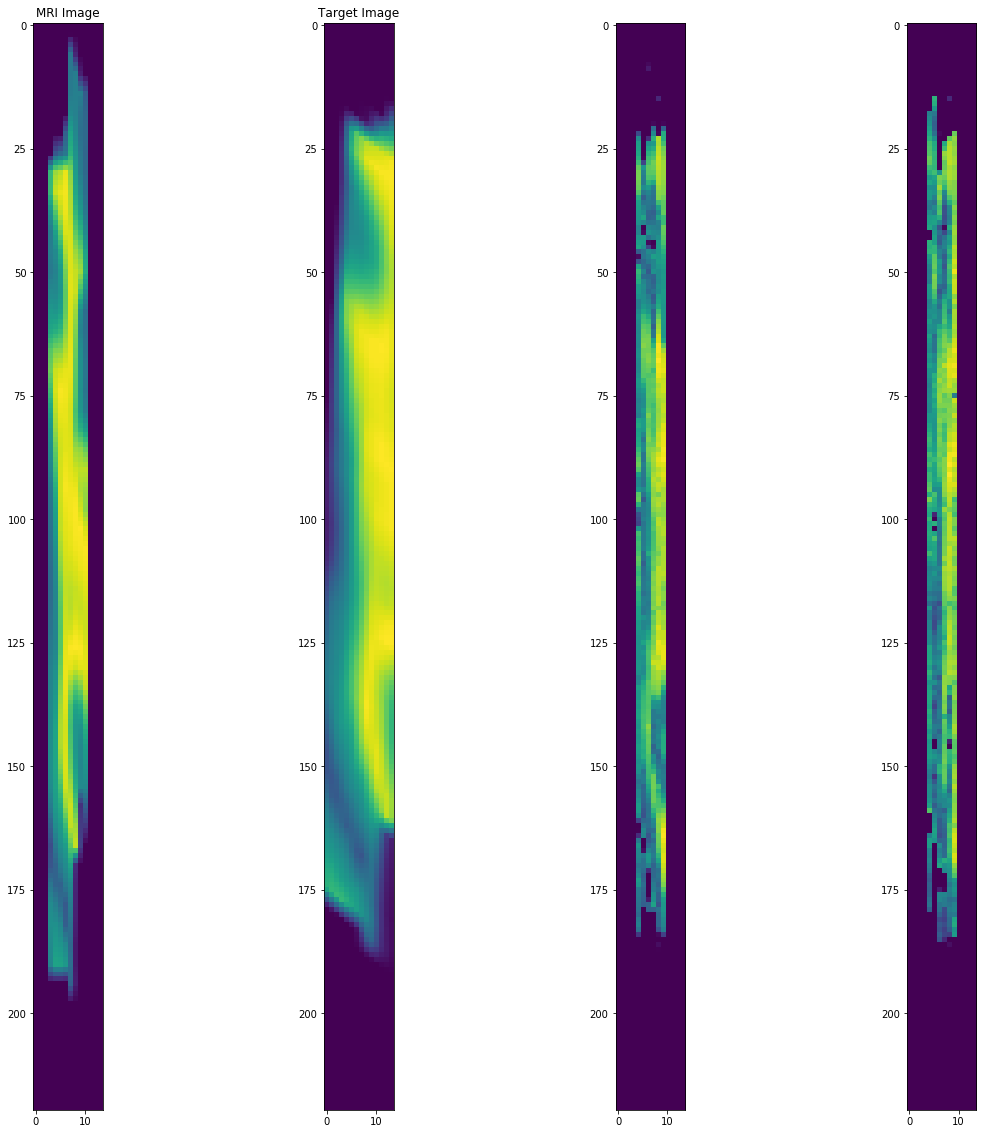

In [32]:
plt.figure()
plt.subplot(1,4,1)
plt.imshow(mri_translated[:,70,:])
plt.title('MRI Image')
plt.subplot(1,4,2)
plt.imshow(mri_translated_rigid[:,70,:])
plt.title('Target Image')
plt.subplot(1,4,3)
plt.imshow(outtarget[:,70,:])
plt.subplot(1,4,4)
plt.imshow(target_resample_arr[:,70,:])
plt.show()


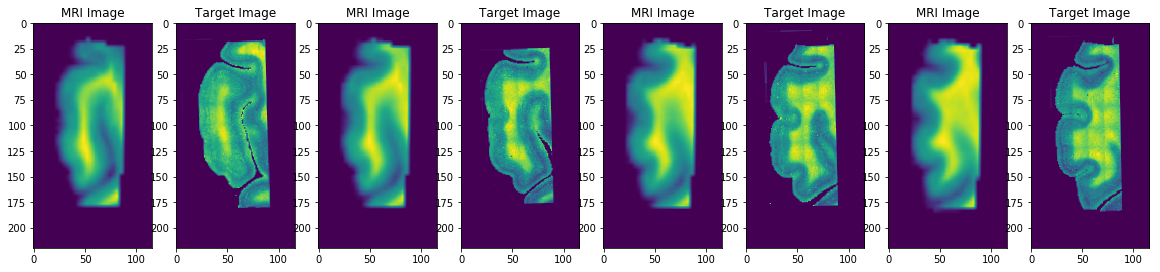

In [9]:
# apply the contrast adjustment to the MRI
#mri_adjusted = (mri_transform_arr - lddmm.ccIbar[0].cpu().numpy()) * lddmm.ccCovIJ[0].cpu().numpy() / lddmm.ccVarI[0].cpu().numpy() + lddmm.ccJbar[0].cpu().numpy()

deformed_mri = (lddmm.applyThisTransform(mri_translated))[0][-1].cpu().numpy()

plt.figure()
plt.subplot(1,8,1)
plt.imshow(deformed_mri[:,:,4])
plt.title('MRI Image')
plt.subplot(1,8,2)
plt.imshow(outtarget[:,:,4])
plt.title('Target Image')
plt.subplot(1,8,3)
plt.imshow(deformed_mri[:,:,5])
plt.title('MRI Image')
plt.subplot(1,8,4)
plt.imshow(outtarget[:,:,5])
plt.title('Target Image')
plt.subplot(1,8,5)
plt.imshow(deformed_mri[:,:,6])
plt.title('MRI Image')
plt.subplot(1,8,6)
plt.imshow(outtarget[:,:,6])
plt.title('Target Image')
plt.subplot(1,8,7)
plt.imshow(deformed_mri[:,:,7])
plt.title('MRI Image')
plt.subplot(1,8,8)
plt.imshow(outtarget[:,:,7])
plt.title('Target Image')
plt.show()

In [ ]:
# resample mri back to original target size
# apply the contrast adjustment to the MRI
mri_adjusted = (mri_resample - lddmm.ccIbar[0].cpu().numpy()) * lddmm.ccCovIJ[0].cpu().numpy() / lddmm.ccVarI[0].cpu().numpy() + lddmm.ccJbar[0].cpu().numpy()

deformed_mri = (lddmm.applyThisTransform(mri_adjusted))[0][-1].cpu().numpy()

mri_sitk = sitk.GetImageFromArray(np.transpose(deformed_mri,(2,1,0)))
mri_sitk.SetSpacing((0.08,0.08,0.08))
mri_sitk_upsampled = sitk.Resample(mri_sitk,
                                   orignisslsize,
                                   sitk.AffineTransform(3),sitk.sitkLinear,(0,0,0),[0.08,0.04,0.08],(1,0,0,0,1,0,0,0,1),0.0)
mri_upsampled = np.transpose(sitk.GetArrayFromImage(mri_sitk_upsampled),(2,1,0))
plt.figure()
plt.subplot(1,4,1)
plt.imshow(mri_upsampled[:,:,100])
plt.title('MRI Image')
plt.subplot(1,4,2)
plt.imshow(target_image[:,:,100])


plt.title('Target Image')
plt.subplot(1,4,3)
plt.imshow(mri_upsampled[96,:,:])
plt.title('MRI Image')
plt.subplot(1,4,4)
plt.imshow(target_image[96,:,:])
plt.title('Target Image')
plt.show()

In [11]:
print(torch.sum(lddmm.It[0][0] - lddmm.It[0][-1]))

tensor(16490361.)


In [ ]:
outmri = nib.AnalyzeImage(mri_upsampled,None)
outmri.header['pixdim'][1:4] = [0.08,0.04,0.08]
nib.save(outmri, '/cis/home/jtrieu/Documents/mri_rigid_upsampled.img')

## Do slice alignment

In [ ]:
directoryname = '/cis/home/leebc/Projects/Mouse_Histology/data/registration/BNBoutput/M519/'

# Grab the indices of the missing slices
missingslices = []
for i in range(target_image.shape[1]):
    if np.unique(target_image[:,i,:]).shape[0] < 3:
        missingslices.append(i)
print(missingslices)


print(torch.tensor(target_image).type(torch.FloatTensor).cuda().shape)
print(torch.tensor(mri_upsampled).type(torch.FloatTensor).cuda().shape)
#origJ = lddmm.J[0].clone()
epsilonxy = 4e-8
epsilontheta=2e-8
a = None
b = None
theta = None

for i in range(1,8):
    if i == 1:
        niter = 600
    elif i < 3:
        niter = 100
    elif i == 7:
        niter = 800
    else:
        #epsilonxy = 2e-10
        #epsilontheta=1e-10
        niter = 200
    
    #a,b,theta,outtarget,epsilonxy,epsilontheta = lddmm.sa(origJ,lddmm.It[0][-1],niter=niter,dim=1,epsilonxy=epsilonxy, epsilontheta=epsilontheta,norm=0,missingslices=missingslices,sigma_atlas=0.75,sigma_target=10.0,a=a,b=b,theta=theta,min_sigma_atlas=1.0)
    a,b,theta,outtarget,epsilonxy,epsilontheta = lddmm.sa(torch.tensor(target_image).type(torch.FloatTensor).cuda(),torch.tensor(mri_upsampled).type(torch.FloatTensor).cuda(),niter=niter,dim=1,norm=0,missingslices=missingslices,sigma_atlas=4.0,sigma_target=50.0,a=a,b=b,theta=theta,nx=list(target_image.shape),dx=[0.08,0.04,0.08],epsilonxy=epsilonxy*4, epsilontheta=epsilontheta*4)
    #lddmm.setParams('a',4)
    outtarget = torch.transpose(lddmm.applySA(torch.tensor(target_image).type(torch.FloatTensor).cuda(), a, b, theta, dim=1,nx=list(target_image.shape),dx=[0.08,0.04,0.08]),2,1).cpu().numpy().astype(np.float32)
    lddmm.setParams('energy_fraction_from',len(lddmm.EAll)-1)
    
    # resample the target image
    #outtarget_ds = sitk.GetArrayFromImage(sitk.Resample(sitk.GetImageFromArray(np.transpose(outtarget,(2,1,0))), [outtarget.shape[0],int(np.round(outtarget.shape[1]/2.0)), outtarget.shape[2]], sitk.AffineTransform(3), sitk.sitkLinear, (0,0,0),[0.08,0.08,0.08],(1,0,0,0,1,0,0,0,1),0.0)
    outtarget_np = sitk.GetImageFromArray(np.transpose(outtarget,(2,1,0)))
    outtarget_np.SetSpacing((0.08,0.04,0.08))
    outtarget_ds = np.transpose(sitk.GetArrayFromImage(sitk.Resample(outtarget_np, deformed_mri.shape, sitk.AffineTransform(3), sitk.sitkLinear, (0,0,0),[0.08,0.08,0.08],(1,0,0,0,1,0,0,0,1),0.0)),(2,1,0))
    
    #lddmm.J[0] = torch.transpose(outtarget,2,1)
    lddmm.J[0] = torch.tensor(outtarget_ds).type(torch.FloatTensor).cuda()
    # reset beta
    if i > 1:
        lddmm.setParams('epsilonL',lddmm.GDBetaAffineR*lddmm.params['epsilonL']*4) # reduce step size, here we set it to the current size
    
    lddmm.setParams('epsilonT',lddmm.GDBetaAffineT*lddmm.params['epsilonT']*4) # reduce step size, here we set it to the current size
    #lddmm.GDBeta = torch.tensor(1.0).type(lddmm.params['dtype']).to(device=lddmm.params['cuda'])
    #lddmm.GDBetaAffineR = float(1.0)
    #lddmm.GDBetaAffineT = float(1.0)
    lddmm.setParams('niter',40)
    lddmm.run()
    
    # resample the mri image
    deformed_mri = (lddmm.applyThisTransform(mri_adjusted))[0][-1].cpu().numpy()
    mri_sitk = sitk.GetImageFromArray(np.transpose(deformed_mri,(2,1,0)))
    mri_sitk.SetSpacing((0.08,0.08,0.08))
    mri_sitk_upsampled = sitk.Resample(mri_sitk,orignisslsize,sitk.AffineTransform(3),sitk.sitkLinear,(0,0,0),[0.08,0.04,0.08],(1,0,0,0,1,0,0,0,1),0.0)
    mri_upsampled = np.transpose(sitk.GetArrayFromImage(mri_sitk_upsampled),(2,1,0))
    
    ##save
    #outimg = nib.AnalyzeImage(lddmm.It[0][-1].to('cpu').numpy(),None)
    #outimg.header['pixdim'][1:4] = [0.04,0.04,0.04]
    #nib.save(outimg,directoryname + 'atlas_lddmm_rnaiter' + str(i) + '.img')
    #outimg = nib.AnalyzeImage(np.transpose(outtarget.to('cpu').numpy(),(0,2,1)),None)
    #outimg.header['pixdim'][1:4] = [0.04,0.04,0.04]
    #nib.save(outimg,directoryname + 'target_lddmm_rnaiter' + str(i) + '.img')
    ## transform annotation
    #outanno = lddmm.applyThisTransform(anno,interpmode='nearest')
    #outimg = nib.AnalyzeImage(outanno[0][-1].to('cpu').numpy(),None)
    #outimg.header['pixdim'][1:4] = [0.04,0.04,0.04]
    #nib.save(outimg,directoryname + 'anno_lddmm_rnaiter' + str(i) + '.img')

In [ ]:
plt.figure()
plt.subplot(1,4,1)
plt.imshow(mri_upsampled[:,:,100])
plt.title('MRI Image')
plt.subplot(1,4,2)
plt.imshow(outtarget[:,:,100])
plt.title('Target Image')
plt.subplot(1,4,3)
plt.imshow(mri_upsampled[96,:,:])
plt.title('MRI Image')
plt.subplot(1,4,4)
plt.imshow(outtarget[96,:,:])
plt.title('Target Image')
plt.show()

In [ ]:
# write out transforms
aout = a.cpu().numpy()
bout = b.cpu().numpy()
tout = theta.cpu().numpy()
aout = np.delete(aout,missingslices)
bout = np.delete(bout,missingslices)
tout = np.delete(tout,missingslices)
np.savetxt('/cis/home/leebc/Projects/Mouse_Histology/data/registration/BNBoutput/M519/M519_final_a.txt',aout,delimiter='\n')
np.savetxt('/cis/home/leebc/Projects/Mouse_Histology/data/registration/BNBoutput/M519/M519_final_b.txt',bout,delimiter='\n')
np.savetxt('/cis/home/leebc/Projects/Mouse_Histology/data/registration/BNBoutput/M519/M519_final_theta.txt',tout,delimiter='\n')
SAR
# write out rotation center
rotcenter = [outtarget.shape[0]/2.0*0.08, outtarget.shape[2]/2.0*0.08]
np.savetxt('/cis/home/leebc/Projects/Mouse_Histology/data/registration/BNBoutput/M519/M519_rotcenter.txt',rotcenter,delimiter='\n')

# write out the reconstructed target image
outimg = nib.AnalyzeImage(outtarget,None)
outimg.header['pixdim'][1:4] = [0.08,0.04,0.08]marmoset
nib.save(outimg, '/cis/home/jtrieu/Documents/M519_orig_target_STS.img')

In [ ]:
aout = np.loadtxt('/cis/home/leebc/Projects/Mouse_Histology/data/registration/BNBoutput/M519/M519_final_a.txt',delimiter='\n')
bout = np.loadtxt('/cis/home/leebc/Projects/Mouse_Histology/data/registration/BNBoutput/M519/M519_final_b.txt',delimiter='\n')
tout = np.loadtxt('/cis/home/leebc/Projects/Mouse_Histology/data/registration/BNBoutput/M519/M519_final_theta.txt',delimiter='\n')
rotcenter = np.loadtxt('/cis/home/leebc/Projects/Mouse_Histology/data/registration/BNBoutput/M519/M519_rotcenter.txt',delimiter='\n')
file = open('/cis/home/leebc/Projects/Mouse_Histology/data/registration/BNBoutput/M519/M519_XForm_matrix.txt','w')
for i in range(len(aout)):
    file.write(str(np.cos(tout[i])) + ',' + str(-1*np.sin(tout[i])) + ',' + str(np.sin(tout[i])) + ',' + str(np.cos(tout[i])) + ',' + str(aout[i]) + ',' + str(bout[i]) + ',' + str(rotcenter[0]) + ',' + str(rotcenter[1]) + '\n')

file.close()

## Map atlas to reconstructed target

In [ ]:
# i/o
target_image = nib.load('/cis/home/leebc/Projects/Mouse_Histology/data/registration/BNBoutput/M519/M519_orig_target_STS.img').get_data().astype(np.float32)
template_image = np.squeeze(nib.load('/cis/home/leebc/Projects/Mouse_Histology/data/marmoset/hashikawa/atlas_80_flip_masked_eroded_refined.img').get_data().astype(np.float32))
dx = [0.08,0.08,0.08]

# downsample the target
target_sitk = sitk.GetImageFromArray(np.transpose(target_image,(2,1,0)))
target_sitk.SetSpacing((0.08,0.04,0.08))
target_ds = np.transpose(sitk.GetArrayFromImage(sitk.Resample(target_sitk, [target_image.shape[0],int(np.round(target_image.shape[1]/2.0)),target_image.shape[2]], sitk.AffineTransform(3), sitk.sitkLinear, (0,0,0),[0.08,0.08,0.08],(1,0,0,0,1,0,0,0,1),0.0)),(2,1,0))

# pad the atlas and the target
templatepadsize = [max(target_ds.shape[0],template_image.shape[0]), max(int(np.round(target_image.shape[1]/2.0)),template_image.shape[1]), max(target_ds.shape[2],template_image.shape[2])]
target_padded = np.zeros(templatepadsize)
target_padded[0:target_ds.shape[0],0:target_ds.shape[1],0:target_ds.shape[2]] = np.copy(target_ds)
template_padded = np.zeros(templatepadsize)
template_padded[0:template_image.shape[0],0:template_image.shape[1],0:template_image.shape[2]] = np.copy(template_image)

## Do affine alignment

In [ ]:

lddmm = torch_lddmm.LDDMM(template=[template_padded],target=[target_padded],costmask=None,outdir='../notebook/',do_affine=2,do_lddmm=0,a=8,niter=150,epsilon=5e-3,sigma=[20.0],sigmaR=10.0,optimizer='gdr',dx=dx,cc=1,epsilonL=4e-8,epsilonT=8e-6)
torch.cuda.empty_cache()

In [ ]:
lddmm.run()

In [ ]:
lddmm.setParams('do_affine',1)
#lddmm.setParams('epsilonL',lddmm.GDBetaAffineR*lddmm.params['epsilonL']*4) # reduce step size, here we set it to the current size
#lddmm.setParams('epsilonT',lddmm.GDBetaAffineT*lddmm.params['epsilonT']*4) # reduce step size, here we set it to the current size
lddmm.setParams('epsilonL',4e-8)
lddmm.setParams('epsilonT',8e-6)
lddmm.setParams('niter',500)
lddmm.run()

In [ ]:

plt.rcParams["figure.figsize"]=20,20
plt.figure()
plt.subplot(1,4,1)
plt.imshow(target_padded[:,:,100])
plt.title('Target Image')
plt.subplot(1,4,2)
plt.imshow(lddmm.It[0][-1].cpu().numpy()[:,:,100])
plt.title('Deformed Template')
plt.subplot(1,4,3)
plt.imshow(target_padded[96,:,:])
plt.title('Target Image')
plt.subplot(1,4,4)
plt.imshow(lddmm.It[0][-1].cpu().numpy()[96,:,:])
plt.title('Deformed Template')
plt.show()

In [ ]:

# save the affine transform
A = lddmm.affineA.cpu().numpy()
file = open('/cis/home/leebc/Projects/Mouse_Histology/data/registration/BNBoutput/M519/M519_affine_transform.txt','w')
file.write(str(A[0,0]) + '\n')
file.write(str(A[0,1]) + '\n')
file.write(str(A[0,2]) + '\n')
file.write(str(A[1,0]) + '\n')
file.write(str(A[1,1]) + '\n')
file.write(str(A[1,2]) + '\n')
file.write(str(A[2,0]) + '\n')
file.write(str(A[2,1]) + '\n')
file.write(str(A[2,2]) + '\n')
file.write(str(A[3,0]) + '\n')
file.write(str(A[3,1]) + '\n')
file.write(str(A[3,2]) + '\n')
file.write(str(target_padded.shape[0]/2.0) + '\n')
file.write(str(target_padded.shape[1]/2.0) + '\n')
file.write(str(target_padded.shape[2]/2.0) + '\n')
file.close()

## crop images back to original size

In [ ]:
template_affine = lddmm.It[0][-1].cpu().numpy()[0:target_ds.shape[0],0:target_ds.shape[1],0:target_ds.shape[2]]
outimg = nib.AnalyzeImage(template_affine,None)
outimg.header['pixdim'][1:4] = [0.08,0.08,0.08]
nib.save(outimg, '/cis/home/leebc/Projects/Mouse_Histology/data/registration/BNBoutput/M519/M519_affine.img')

# transform the annotation
anno = np.squeeze(nib.load('/cis/home/leebc/Projects/Mouse_Histology/data/marmoset/hashikawa/annotation_80_flip.img').get_data().astype(np.float32))
anno_padded = np.zeros(templatepadsize)
anno_padded[0:anno.shape[0],0:anno.shape[1],0:anno.shape[2]] = np.copy(anno)

deformed_anno,_,_,_ = lddmm.applyThisTransform(anno_padded,interpmode='nearest')
deformed_anno = (deformed_anno[-1].cpu().numpy())[0:target_ds.shape[0],0:target_ds.shape[1],0:target_ds.shape[2]]
outimg = nib.AnalyzeImage(deformed_anno,None)
outimg.header['pixdim'][1:4] = [0.08,0.08,0.08]
nib.save(outimg, '/cis/home/leebc/Projects/Mouse_Histology/data/registration/BNBoutput/M519/M519_annotation_affine.img')

## Do LDDMM

In [ ]:

template_affine = nib.load('/cis/home/leebc/Projects/Mouse_Histology/data/registration/BNBoutput/M519/M519_affine.img').get_data().astype(np.float32)
# i/o
target_image = nib.load('/cis/home/leebc/Projects/Mouse_Histology/data/registration/BNBoutput/M519/M519_orig_target_STS.img').get_data().astype(np.float32)
#template_image = np.squeeze(nib.load('/cis/home/leebc/Projects/Mouse_Histology/data/marmoset/hashikawa/atlas_80_flip_masked_eroded_refined.img').get_data().astype(np.float32))
dx = [0.08,0.08,0.08]

# downsample the target
target_sitk = sitk.GetImageFromArray(np.transpose(target_image,(2,1,0)))
target_sitk.SetSpacing((0.08,0.04,0.08))
target_ds = np.transpose(sitk.GetArrayFromImage(sitk.Resample(target_sitk, [target_image.shape[0],int(np.round(target_image.shape[1]/2.0)),target_image.shape[2]], sitk.AffineTransform(3), sitk.sitkLinear, (0,0,0),[0.08,0.08,0.08],(1,0,0,0,1,0,0,0,1),0.0)),(2,1,0))

lddmm = torch_lddmm.LDDMM(template=[template_affine],target=[target_ds],costmask=None,outdir='../notebook/',do_affine=0,do_lddmm=1,a=8,niter=250,epsilon=2e-2,sigma=[20.0],sigmaR=10.0,optimizer='gdr',dx=dx,cc=1,nt=4,low_memory=1)
torch.cuda.empty_cache()

In [ ]:
lddmm.run()


In [ ]:

anno_sitk = sitk.GetImageFromArray(np.transpose(deformed_anno,(2,1,0)))
anno_sitk.SetSpacing((0.08,0.08,0.08))
anno_us = sitk.Resample(anno_sitk,orignisslsize,sitk.AffineTransform(3),sitk.sitkNearestNeighbor,(0,0,0),[0.08,0.04,0.08],(1,0,0,0,1,0,0,0,1),0.0)
anno_us = np.transpose(sitk.GetArrayFromImage(anno_us),(2,1,0))
anno_out = nib.AnalyzeImage(anno_us,None)
anno_out.header['pixdim'][1:4] = [0.08,0.04,0.08]
nib.save(anno_out,'/cis/home/leebc/Projects/Mouse_Histology/data/registration/BNBoutput/M519/M519_annotation.img')

In [ ]:
evels = np.unique(anno_us[:,:,100])

plt.figure()
plt.subplot(1,2,1)
plt.imshow(target_image[:,:,100],cmap='gray')
plt.title('Target')
for i in range(levels.shape[0]):
    plt.contour((anno_us[:,:,100]==levels[i])*1.0,0.999,colors='r')

levels = np.unique(anno_us[96,:,:])
plt.subplot(1,2,2)
plt.imshow(target_image[96,:,:],cmap='gray')
plt.title('Target')
for i in range(levels.shape[0]):
    plt.contour((anno_us[96,:,:]==levels[i])*1.0,0.999,colors='r')

plt.show()

In [ ]:

# save transforms
vt0,vt1,vt2 = lddmm.outputTransforms()
np.save('/cis/home/leebc/Projects/Mouse_Histology/data/registration/BNBoutput/M519/M519_vt0.npy',vt0)
np.save('/cis/home/leebc/Projects/Mouse_Histology/data/registration/BNBoutput/M519/M519_vt1.npy',vt1)
np.save('/cis/home/leebc/Projects/Mouse_Histology/data/registration/BNBoutput/M519/M519_vt2.npy',vt2)

In [ ]:
## Warp MRI to reconstructed target

In [ ]:
target_file_name = '/cis/home/leebc/Projects/Mouse_Histology/data/registration/BNBoutput/M519/M519_orig_target_STS.img'
mri_file_name = '/cis/home/leebc/Projects/Mouse_Histology/data/registration/BNBoutput/M519/M519_mri_full.img'

target_image = nib.load(target_file_name).get_data().astype(np.float32)
mri_image = nib.load(mri_file_name).get_data().astype(np.float32)

mripadsize = [max(target_image.shape[0],int(np.round(mri_image.shape[0]*0.06/0.08))), max(int(np.round(target_image.shape[1]/2.0)),int(np.round(mri_image.shape[1]*0.06/0.08))), max(target_image.shape[2],int(np.round(mri_image.shape[2]*0.06/0.08)))]

target_sitk = sitk.ReadImage(target_file_name)
target_sitk_resample = sitk.Resample(target_sitk,mripadsize,sitk.AffineTransform(3),sitk.sitkLinear,(0,0,0),[0.08,0.08,0.08],(1,0,0,0,1,0,0,0,1),0.0)
print(target_sitk_resample.GetSize())
target_resample = np.transpose(sitk.GetArrayFromImage(target_sitk_resample),(2,1,0))
print(target_resample.shape)

mri_sitk = sitk.ReadImage(mri_file_name)
print(mri_sitk.GetSize())
mri_sitk_resample = sitk.Resample(mri_sitk,target_resample.shape,sitk.AffineTransform(3),sitk.sitkLinear,(0,0,0),[0.08,0.08,0.08],(1,0,0,0,1,0,0,0,1),0.0)
print(mri_sitk_resample.GetSize())
mri_resample = np.transpose(sitk.GetArrayFromImage(mri_sitk_resample),(2,1,0))
print(mri_resample.shape)

#target_padded = np.zeros(mripadsize)
#target_padded[0:target_image.shape[0],0:target_image.shape[1],0:target_image.shape[2]] = np.copy(target_image)
#mri_padded = np.zeros(mripadsize)
#mri_padded[0:mri_image.shape[0],0:mri_image.shape[1],0:mri_image.shape[2]] = np.copy(mri_image)

In [ ]:
dx=[0.08,0.08,0.08]
lddmm = torch_lddmm.LDDMM(template=[mri_resample],target=[target_resample],costmask=None,outdir='../notebook/',do_affine=2,do_lddmm=0,a=8,niter=150,epsilon=5e-3,sigma=[20.0],sigmaR=10.0,optimizer='gdr',dx=dx,cc=1)
lddmm.run()

In [ ]:
lddmm.setParams('do_affine',1)
lddmm.run()


In [ ]:
# save transforms
# save the affine transform
A = lddmm.affineA.cpu().numpy()
file = open('/cis/home/leebc/Projects/Mouse_Histology/data/registration/BNBoutput/M519/M519_MRI_affine_transform.txt','w')
file.write(str(A[0,0]) + '\n')
file.write(str(A[0,1]) + '\n')
file.write(str(A[0,2]) + '\n')
file.write(str(A[1,0]) + '\n')
file.write(str(A[1,1]) + '\n')
file.write(str(A[1,2]) + '\n')
file.write(str(A[2,0]) + '\n')
file.write(str(A[2,1]) + '\n')
file.write(str(A[2,2]) + '\n')
file.write(str(A[3,0]) + '\n')
file.write(str(A[3,1]) + '\n')
file.write(str(A[3,2]) + '\n')
file.write(str(target_resample.shape[0]/2.0) + '\n')
file.write(str(target_resample.shape[1]/2.0) + '\n')
file.write(str(target_resample.shape[2]/2.0) + '\n')
file.close()

In [ ]:
# crop the MRI back to original target size

target_sitk = sitk.ReadImage(target_file_name)
target_sitk_resample = sitk.Resample(target_sitk,[target_sitk.GetSize()[0],int(np.round(target_sitk.GetSize()[1]/2.0)),target_sitk.GetSize()[2]],sitk.AffineTransform(3),sitk.sitkLinear,(0,0,0),[0.08,0.08,0.08],(1,0,0,0,1,0,0,0,1),0.0)
print(target_sitk_resample.GetSize())
target_resample = np.transpose(sitk.GetArrayFromImage(target_sitk_resample),(2,1,0))
print(target_resample.shape)

mri_affine = lddmm.It[0][-1].cpu().numpy()
mri_affine = mri_affine[0:target_resample.shape[0], 0:target_resample.shape[1],0:target_resample.shape[2]]

In [ ]:

lddmm = torch_lddmm.LDDMM(template=[mri_affine],target=[target_resample],costmask=None,outdir='../notebook/',do_affine=0,do_lddmm=1,a=8,niter=250,epsilon=2e-2,sigma=[20.0],sigmaR=10.0,optimizer='gdr',dx=dx,cc=1,nt=4,low_memory=1)
torch.cuda.empty_cache()

In [ ]:
lddmm.run()


In [ ]:
deformed_mri,_,_,_ = lddmm.applyThisTransform(mri_affine,interpmode='bilinear')
deformed_mri = deformed_mri[-1].cpu().numpy()

plt.rcParams["figure.figsize"]=20,20
plt.figure()
plt.subplot(1,4,1)
plt.imshow(target_resample[:,:,100])
plt.title('Target Image')
plt.subplot(1,4,2)
plt.imshow(deformed_mri[:,:,100])
plt.title('Deformed Template')
plt.subplot(1,4,3)
plt.imshow(target_resample[96,:,:])
plt.title('Target Image')
plt.subplot(1,4,4)
plt.imshow(deformed_mri[96,:,:])
plt.title('Deformed Template')
plt.show()

out_mri = nib.AnalyzeImage(deformed_mri, None)
out_mri.header['pixdim'][1:4] = [0.08,0.08,0.08]
nib.save(out_mri, '/cis/home/leebc/Projects/Mouse_Histology/data/registration/BNBoutput/M519/M519_MRI_lddmm.img')

In [ ]:
# save transforms
vt0,vt1,vt2 = lddmm.outputTransforms()
np.save('/cis/home/leebc/Projects/Mouse_Histology/data/registration/BNBoutput/M519/M519_MRI_vt0.npy',vt0)
np.save('/cis/home/leebc/Projects/Mouse_Histology/data/registration/BNBoutput/M519/M519_MRI_vt1.npy',vt1)
np.save('/cis/home/leebc/Projects/Mouse_Histology/data/registration/BNBoutput/M519/M519_MRI_vt2.npy',vt2)